# **Employee Churn Predictor - ML Process**

## Context

TechNova Solutions, a mid-sized IT services company with ~1,200 employees, has been facing an attrition rate well above industry standards. Despite offering competitive salaries and benefits, the company struggles to retain talent, particularly in technical and client-facing roles. This turnover has increased costs, delayed projects, and reduced overall employee satisfaction.  

The Employee Churn Predictor is intended to predict whether an employee is about to leave the company by implementing classification models trained on historical data. A secondary goal is to identify key factors that contribute to churn, enabling the company to design targeted strategies that improve employee retention.

In practice, the system will generate churn probability scores for individual employees and highlight the most influential factors driving attrition. These insights will be provided to HR and management teams, enabling proactive retention measures such as targeted engagement programs, career development opportunities, or workload adjustments. Over time, the solution can be scaled into an integrated HR analytics dashboard, supporting continuous monitoring of employee retention trends and helping the company reduce costs and improve workforce stability.

## Problem Statement

TechNova Solutions is experiencing an employee attrition rate that exceeds industry standards, particularly among technical and client-facing roles. This high turnover increases recruitment and training costs, delays project delivery, and negatively impacts employee morale. The company currently lacks a data-driven mechanism to anticipate which employees are at risk of leaving and to identify the main factors driving this behavior.

## Objectives & Scope

- Identify the most relevant factors that contribute to employee attrition.
- Build a predictive model that can classify whether an employee is likely to leave with a Recall above 85%.
- Provide actionable recommendations that can help HR improve retention and employee satisfaction.

> Requirements not mentioned in this section are out of the scope, however, future stages are proposed below as future work for this especification.

## Data Understanding

In [1]:
# Import libraries required for the analysis
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, precision_recall_curve, recall_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
# Load dataset
df = pd.read_csv('data/employee_churn_dataset.csv', sep=',', index_col=False, header = 0)
print(f'Dataset Shape: {df.shape}')
df.head(10)

Dataset Shape: (10000, 22)


,Employee ID,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,...,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
0,E00001,50,Male,Bachelor's,Married,5,Analyst,Marketing,93422,Remote,...,35,0,16,0.03,Poor,155,14,15,7.9,0
1,E00002,36,Male,Bachelor's,Married,4,Manager,Sales,44589,On-site,...,1,0,12,0.39,Average,162,2,8,5.2,0
2,E00003,29,Male,Bachelor's,Married,3,Sales,IT,56768,Hybrid,...,41,0,2,0.62,Poor,243,6,21,6.3,0
3,E00004,42,Male,Bachelor's,Single,12,Analyst,Sales,79009,On-site,...,33,0,8,0.73,Good,291,11,25,7.4,0
4,E00005,40,Other,Bachelor's,Married,1,Sales,HR,81982,On-site,...,30,0,13,0.52,Average,272,3,1,4.1,0
5,E00006,44,Male,Bachelor's,Single,12,Developer,HR,82669,On-site,...,68,0,2,0.06,Average,266,4,40,2.1,0
6,E00007,32,Male,High School,Married,12,Analyst,Marketing,127951,On-site,...,19,0,35,0.76,Average,233,10,10,4.9,0
7,E00008,32,Male,Master's,Single,6,Manager,Sales,93655,Remote,...,37,0,19,0.39,Average,204,1,14,7.3,0
8,E00009,45,Female,Master's,Single,4,Analyst,Sales,69050,Remote,...,74,0,45,0.18,Excellent,162,15,36,4.9,1
9,E00010,57,Male,High School,Married,12,Developer,Marketing,106153,Hybrid,...,94,0,17,0.26,Good,151,19,27,4.7,0


In [3]:
# Check for datatypes, null-values and columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Employee ID                   10000 non-null  object 
 1   Age                           10000 non-null  int64  
 2   Gender                        10000 non-null  object 
 3   Education Level               10000 non-null  object 
 4   Marital Status                10000 non-null  object 
 5   Tenure                        10000 non-null  int64  
 6   Job Role                      10000 non-null  object 
 7   Department                    10000 non-null  object 
 8   Salary                        10000 non-null  int64  
 9   Work Location                 10000 non-null  object 
 10  Performance Rating            10000 non-null  int64  
 11  Projects Completed            10000 non-null  int64  
 12  Training Hours                10000 non-null  int64  
 13  Pr

In [4]:
#Check missing values
missing_values = df.isna().sum()
# print(type(missing_values.iloc[0]))
missing_values_percentage = (df.isna().mean()*100).apply(lambda x: (f"{x:.1f}%"))
missing_df = pd.DataFrame({'Missing' : missing_values, 
                           '% Missing' : missing_values_percentage
                           })
missing_df

,Missing,% Missing
Employee ID,0,0.0%
Age,0,0.0%
Gender,0,0.0%
Education Level,0,0.0%
Marital Status,0,0.0%
Tenure,0,0.0%
Job Role,0,0.0%
Department,0,0.0%
Salary,0,0.0%
Work Location,0,0.0%


The dataset contains 10,000 records corresponding to TechNova's employees and historical data. It includes 22 features, such as Employee ID, Age, Gender, Education Level, Marital Status, Tenure, Job Role, Department, Salary, Work Location, Performance Rating, Projects Completed, Training Hours, Promotions, Overtime Hours, Satisfaction Level, Work-Life Balance, Average Monthly Hours Worked, Absenteeism, Distance from Home, Manager Feedback Score, and Churn.

Data types vary across features. Continuous numeric features include Salary, Satisfaction Level, and Manager Feedback Score, while discrete numeric features include Age, Tenure, Performance Rating, Projects Completed, Training Hours, Promotions, Overtime Hours, Average Monthly Hours Worked, Absenteeism, Distance from Home, and Churn. Ordinal categorical features include Work-Life Balance, and nominal categorical features include Employee ID, Gender, Education Level, Marital Status, Job Role, Department, and Work Location.

The dataset contains no missing values, ensuring completeness for analysis and model training. The Churn column serves as the target variable for predicting employee attrition.


## Exploratory Data Analysis

### Univariate Analysis

#### Outcome variable

In [5]:
# Check the outcome balance. Determine the relative frequency of people who stay or leave.
class_churn = ((df.groupby('Churn').aggregate({'Churn':'count'})/df.shape[0])*100)
class_churn_percentage = class_churn.map(lambda x: f'{x:.2f}%')
class_churn_percentage

,Churn
Churn,
0,79.72%
1,20.28%


<function matplotlib.pyplot.show(close=None, block=None)>

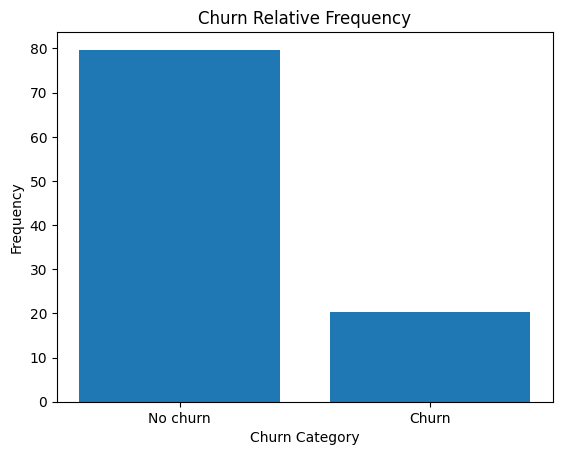

In [6]:
# Plot the outcome feature. Check for class balance

plt.bar(x=class_churn.index.tolist(), height=class_churn['Churn'] )
plt.title('Churn Relative Frequency')
plt.xlabel('Churn Category')
plt.ylabel('Frequency')
plt.xticks(ticks=[0,1], labels=['No churn', 'Churn'])
plt.show

The outcome variable which is Churn, in the figure above, shows a moderate class imbalance. In this context are class imbalance is considered moderate when the minor category is between 10%-30%, severe when it is lower than 5%, and balanced between 40-60%. This analysis will be considered for decision_making in further steps like model parameters configuration.  

In [7]:
df.describe()

,Age,Tenure,Salary,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
count,10000.000000,10000.000000,10000.0000,10000.0000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,40.561200,6.976800,89772.7548,3.0275,24.501200,49.715500,0.101000,24.2506,0.494940,224.53820,9.467700,24.491800,5.565430,0.202800
std,10.876483,4.296988,34469.8058,1.4120,14.444461,28.930822,0.301344,14.4787,0.287771,43.62834,5.758635,14.512491,2.595523,0.402105
min,22.000000,0.000000,30010.0000,1.0000,0.000000,0.000000,0.000000,0.0000,0.000000,150.00000,0.000000,0.000000,1.000000,0.000000
25%,31.000000,3.000000,59718.5000,2.0000,12.000000,24.750000,0.000000,12.0000,0.247500,186.00000,4.000000,12.000000,3.300000,0.000000
50%,41.000000,7.000000,89243.0000,3.0000,24.000000,49.000000,0.000000,24.0000,0.490000,225.00000,9.000000,24.000000,5.600000,0.000000
75%,50.000000,11.000000,119725.5000,4.0000,37.000000,75.000000,0.000000,37.0000,0.740000,262.25000,14.000000,37.000000,7.800000,0.000000
max,59.000000,14.000000,149993.0000,5.0000,49.000000,99.000000,1.000000,49.0000,1.000000,299.00000,19.000000,49.000000,10.000000,1.000000


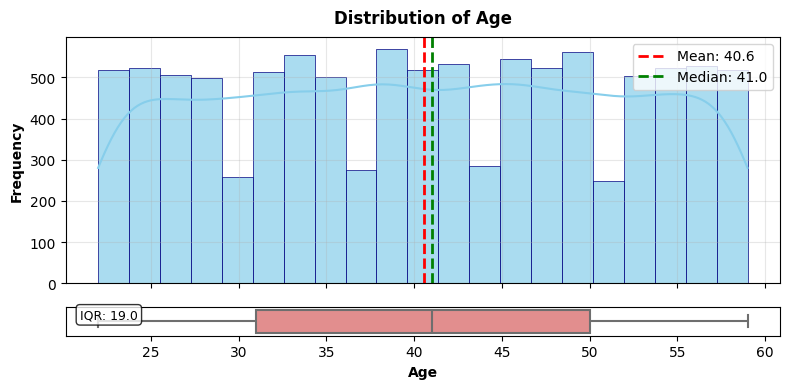

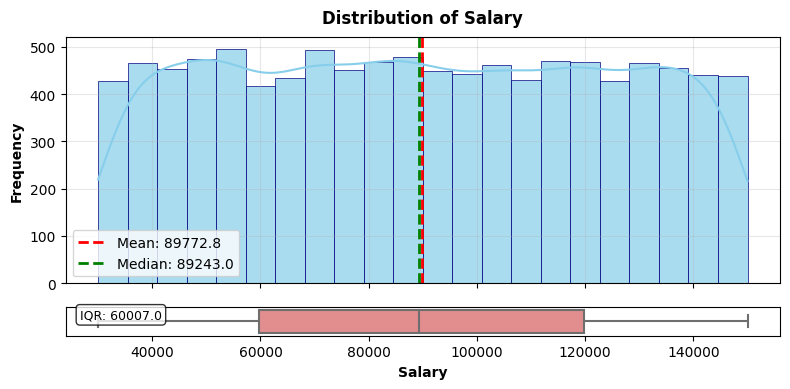

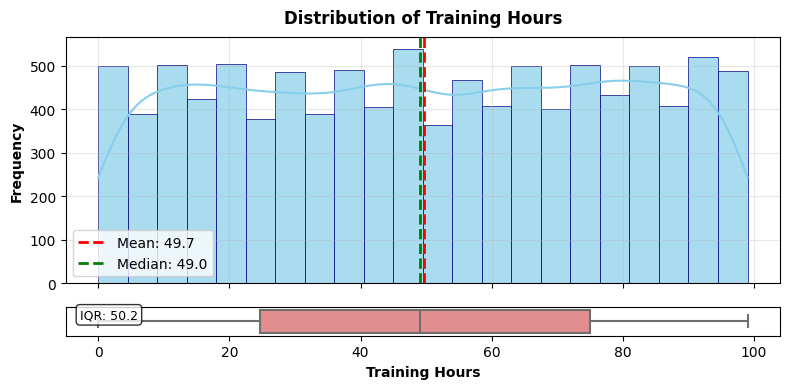

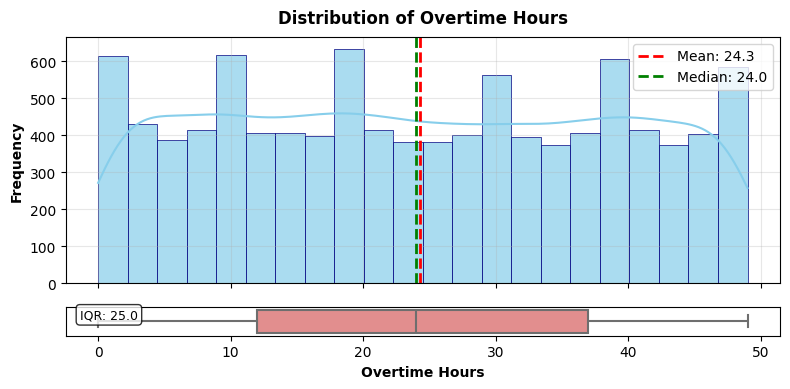

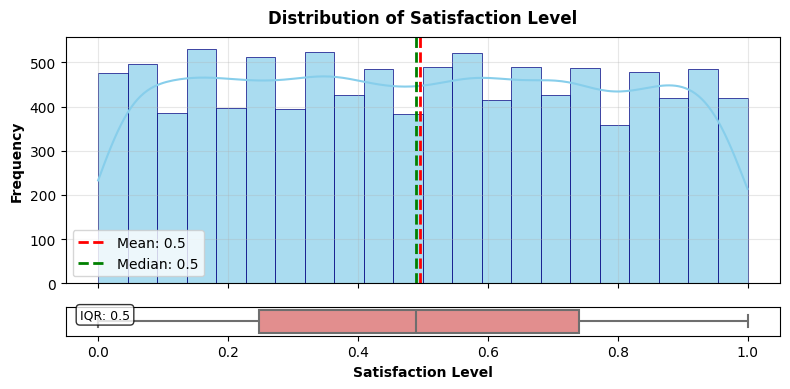

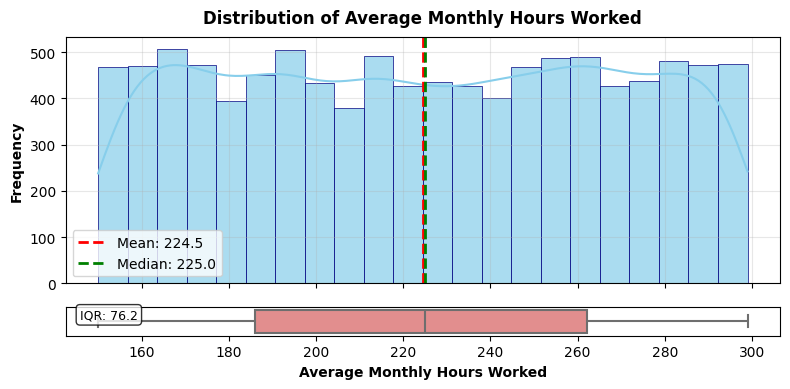

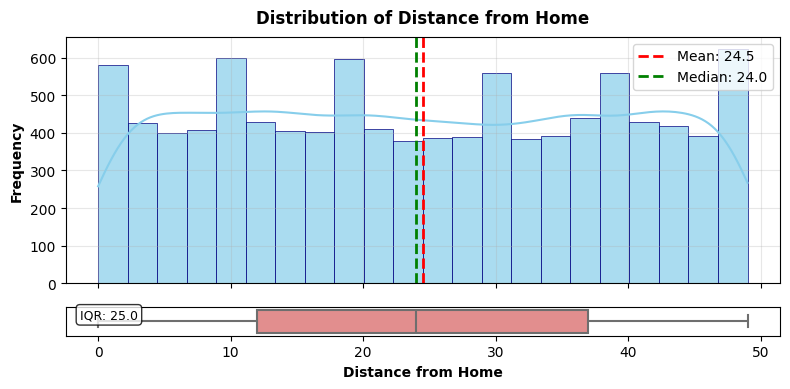

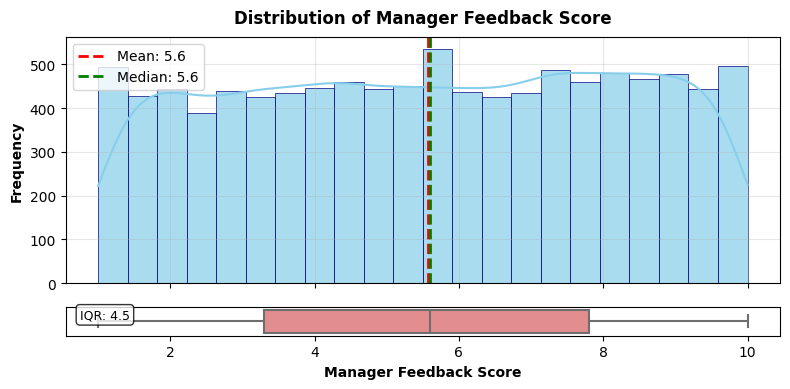

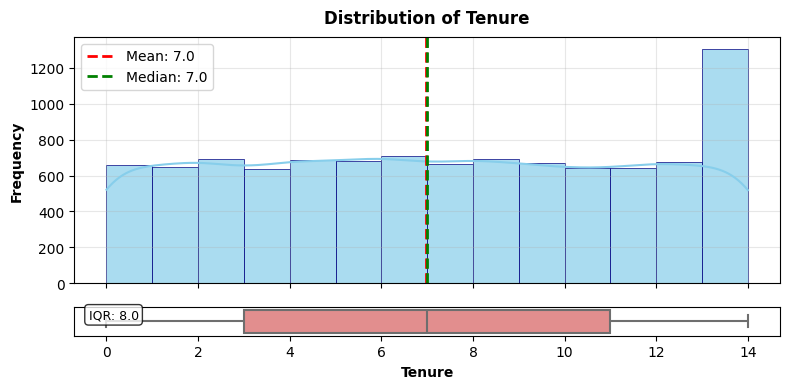

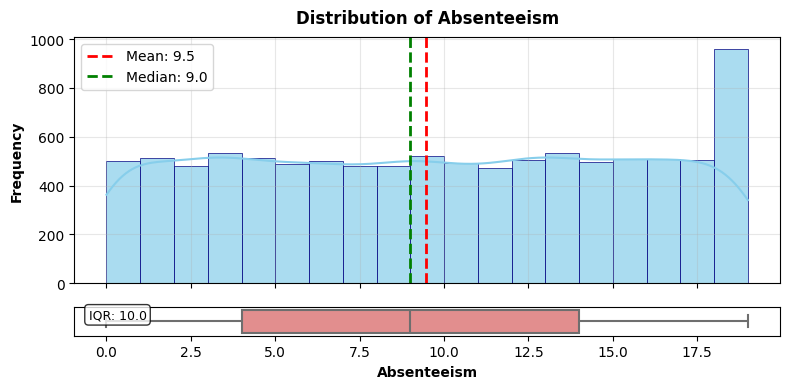

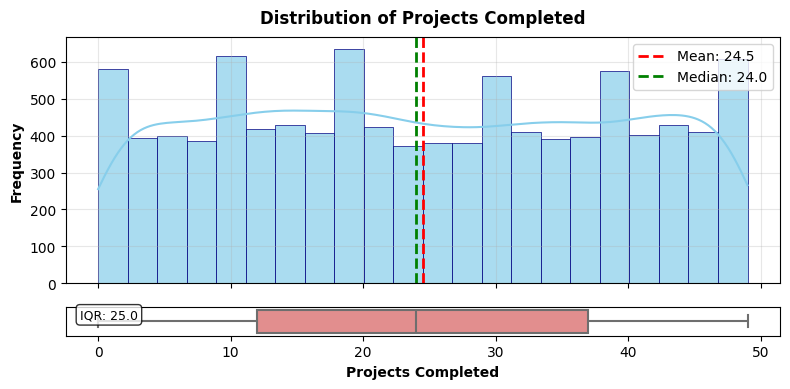

In [8]:
continuous_vars = ['Age', 'Salary', 'Training Hours', 
                   'Overtime Hours', 'Satisfaction Level', 
                   'Average Monthly Hours Worked', 'Distance from Home',
                   'Manager Feedback Score', 'Tenure', 'Absenteeism', 'Projects Completed']

for column in continuous_vars:
    
    bin_edges_fd = np.histogram_bin_edges(df[column], bins='fd')
    n_bins_fd = len(bin_edges_fd) - 1
    
    fig, (ax_hist, ax_box) = plt.subplots(
        2, 1, figsize=(8, 4), 
        gridspec_kw={"height_ratios": (0.85, 0.1)}, 
        sharex=True
    )
    
    sns.histplot(df[column], bins=n_bins_fd, kde=True, ax=ax_hist, 
                 alpha=0.7, color='skyblue', edgecolor='navy', linewidth=0.5)
    
    # Add mean and median lines 
    mean_val = df[column].mean()
    median_val = df[column].median()
    
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax_hist.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    
    ax_hist.legend()
    ax_hist.set_ylabel('Frequency', fontweight='bold')
    ax_hist.grid(True, alpha=0.3)
    ax_hist.set_title(f'Distribution of {column}', fontweight='bold', pad=10)
    
    sns.boxplot(x=df[column], ax=ax_box, color='lightcoral', linewidth=1.5)
    ax_box.set_xlabel(column, fontweight='bold')
    ax_box.set_yticks([])
    
    # Add boxplot statistics 
    q1, q3 = df[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    ax_box.text(0.02, 0.6, f'IQR: {iqr:.1f}', transform=ax_box.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                fontsize=9)
    
    plt.tight_layout()
    plt.show()

Given the analysis and the provided charts, one important observation to add could be the potential implications of the multimodal distributions across most features. This suggests that the dataset might contain distinct subgroups within the employee population, which could be significant for further investigation. For instance:

- Subgroup Analysis: The multimodal nature of features like Age, Projects Completed, Satisfaction Level, Distance from Home, Overtime Hours, Average Monthly Hours Worked, and Training Hours indicates possible clusters (e.g., different departments, roles, or work patterns). This could be explored to understand if these subgroups correlate with other variables like performance or retention.

- Symmetry and Central Tendency: The close proximity of mean and median values across features (e.g., Age: 40.6 vs. 41.0, Satisfaction Level: 0.5 vs. 0.5) suggests that, within each multimodal peak, the distributions are relatively symmetric around their central tendencies. This local stability could be useful for predictive modeling or policy decisions, particularly when analyzing data segmented by these subgroups.

- IQR Variability: The varying IQR values (e.g., 19.0 for Age vs. 0.5 for Satisfaction Level) highlight differing levels of data spread. Features with a wider IQR, like Distance from Home (25.0) or Average Monthly Hours Worked (76.2), might indicate greater diversity in employee lifestyles or work habits, which could be a factor in workforce planning.

    

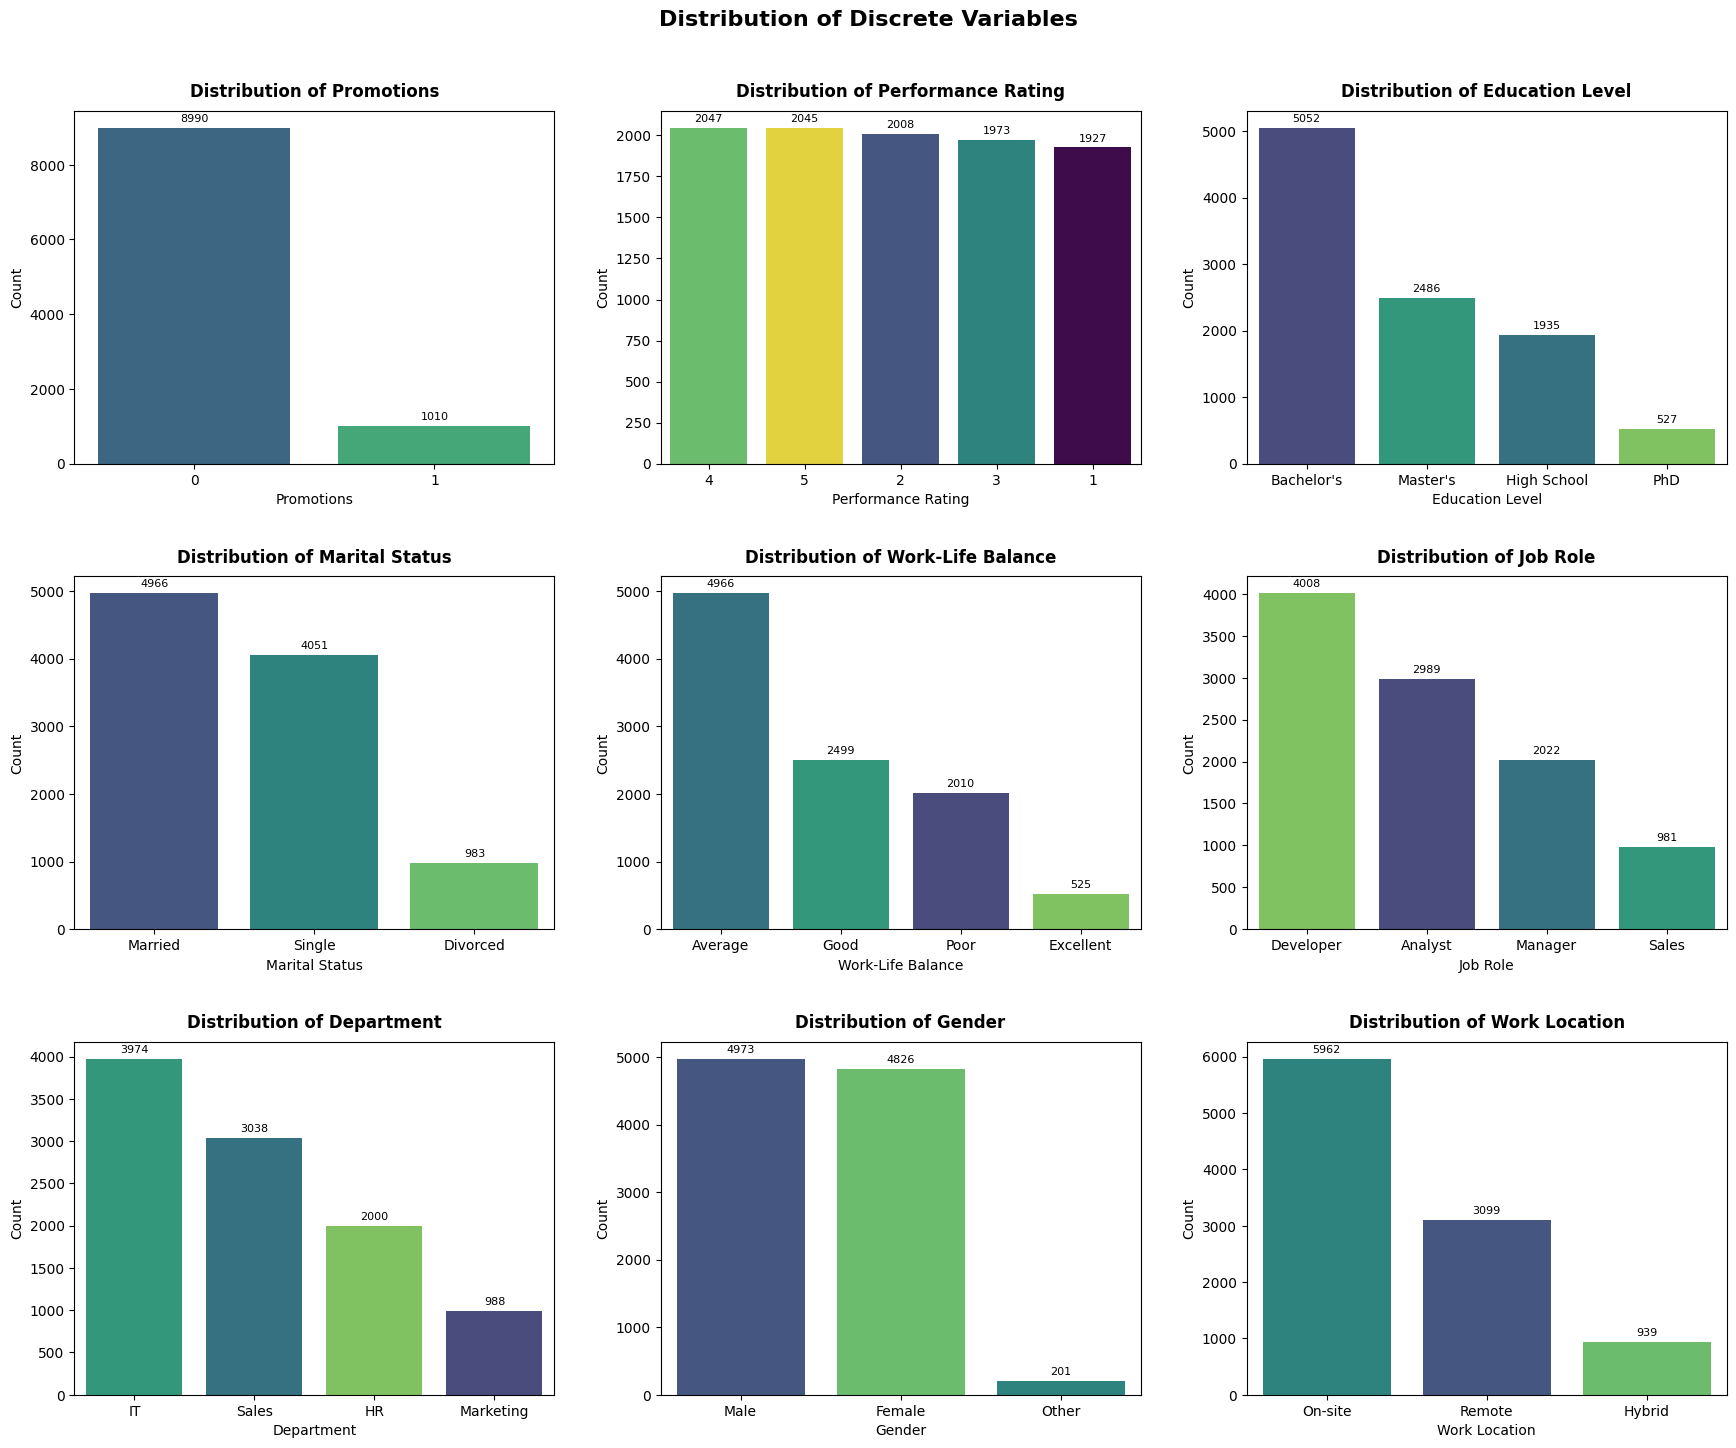

In [9]:
# List of discrete variables for analysis
discrete = ['Promotions', 'Performance Rating', 'Education Level', 'Marital Status', 
            'Work-Life Balance', 'Job Role', 'Department', 'Gender', 'Work Location']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()  

# Plot each discrete variable in its own subplot
for i, feature in enumerate(discrete):
    # Get value counts and sort in descending order
    value_counts = df[feature].value_counts()
    order = value_counts.index
    
    # Create countplot with descending order
    sns.countplot(x=df[feature], hue=df[feature], ax=axes[i], palette='viridis', 
                  legend=False, order=order)
    
    # Set title and format
    axes[i].set_title(f'Distribution of {feature}', fontweight='bold', pad=10)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
    # Rotate x-axis labels if too many categories
    if df[feature].nunique() > 5:
        axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on top of bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', padding=3, fontsize=8)

# Remove any empty subplots if discrete list has less than 9 elements
for i in range(len(discrete), len(axes)):
    fig.delaxes(axes[i])

# Main title for the entire figure with increased spacing between subplots
plt.suptitle('Distribution of Discrete Variables', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.0)
plt.show()

Based on the analysis of the provided charts for discrete variables, the following key observations can be highlighted:

- Imbalanced Distributions Across Variables: The dataset exhibits significant imbalances in the distribution of discrete features. For instance, Promotions are heavily skewed toward 0 (8860 counts) compared to 1 (1010 counts), suggesting a low promotion rate. Similarly, Education Level shows a strong dominance of Bachelor's degrees (5052 counts) over other levels like Master's (2496 counts) or High School (1935 counts), let alone PhD.

- Dominant Categories in Key Features: Certain categories stand out within each variable. Marital Status leans heavily toward Married, with a strong presence at 4066 individuals, followed closely by Single at 4031, while Divorced is less common at 963. Performance Rating shows a clear peak at 3 with 2045 employees, reflecting a common rating level. Work-Life Balance is predominantly Average with 4066 people, with fewer rating it Excellent at 529 or Poor at 2010. Job Role is dominated by Developers at 4008, trailed by Analysts at 2909, and Managers at 2022.

- Gender and Work Location Disparities: The Gender distribution is fairly balanced between Male (4073 counts) and Female (4283 counts), with only a slight difference of 210 counts. The primary imbalance arises from the minimal representation in the "Other" category (201 counts), suggesting a significant underrepresentation of this group compared to the binary genders. This could have implications for diversity initiatives or further investigation into gender demographics within the workforce.

These imbalances and dominant categories could have implications for workforce planning, diversity initiatives, or performance evaluations. The skewed distributions suggest potential areas for targeted analysis to understand underlying factors, such as the impact of education level on job roles or the effect of work-life balance on performance ratings.

### Multivariate Analysis

#### Correlation Matrix

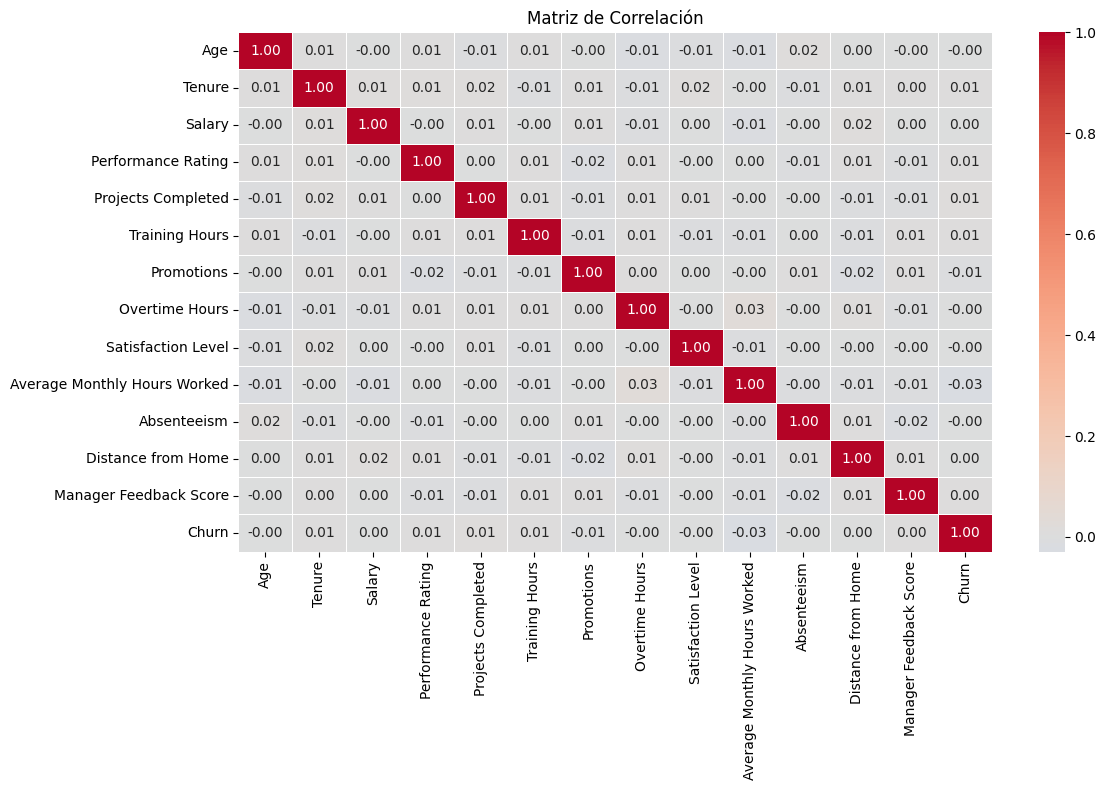

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,          
    cmap='coolwarm',    
    center=0,             
    fmt='.2f',
    linewidths=0.5
)
plt.title('Matriz de Correlación') 
plt.tight_layout()
plt.show()

The correlation matrix reveals that no individual variable exhibits a linear correlation with Churn. This suggests that employee turnover cannot be explained by a single characteristic and is likely influenced by complex interactions among multiple factors. It is recommended to proceed with non-linear models and variable importance analysis to identify the true drivers of churn. Nonetheless, a deep bivariate analysis between the outcome (Churn) and the other features will be performed in the subsequent steps to capture additional insights. 

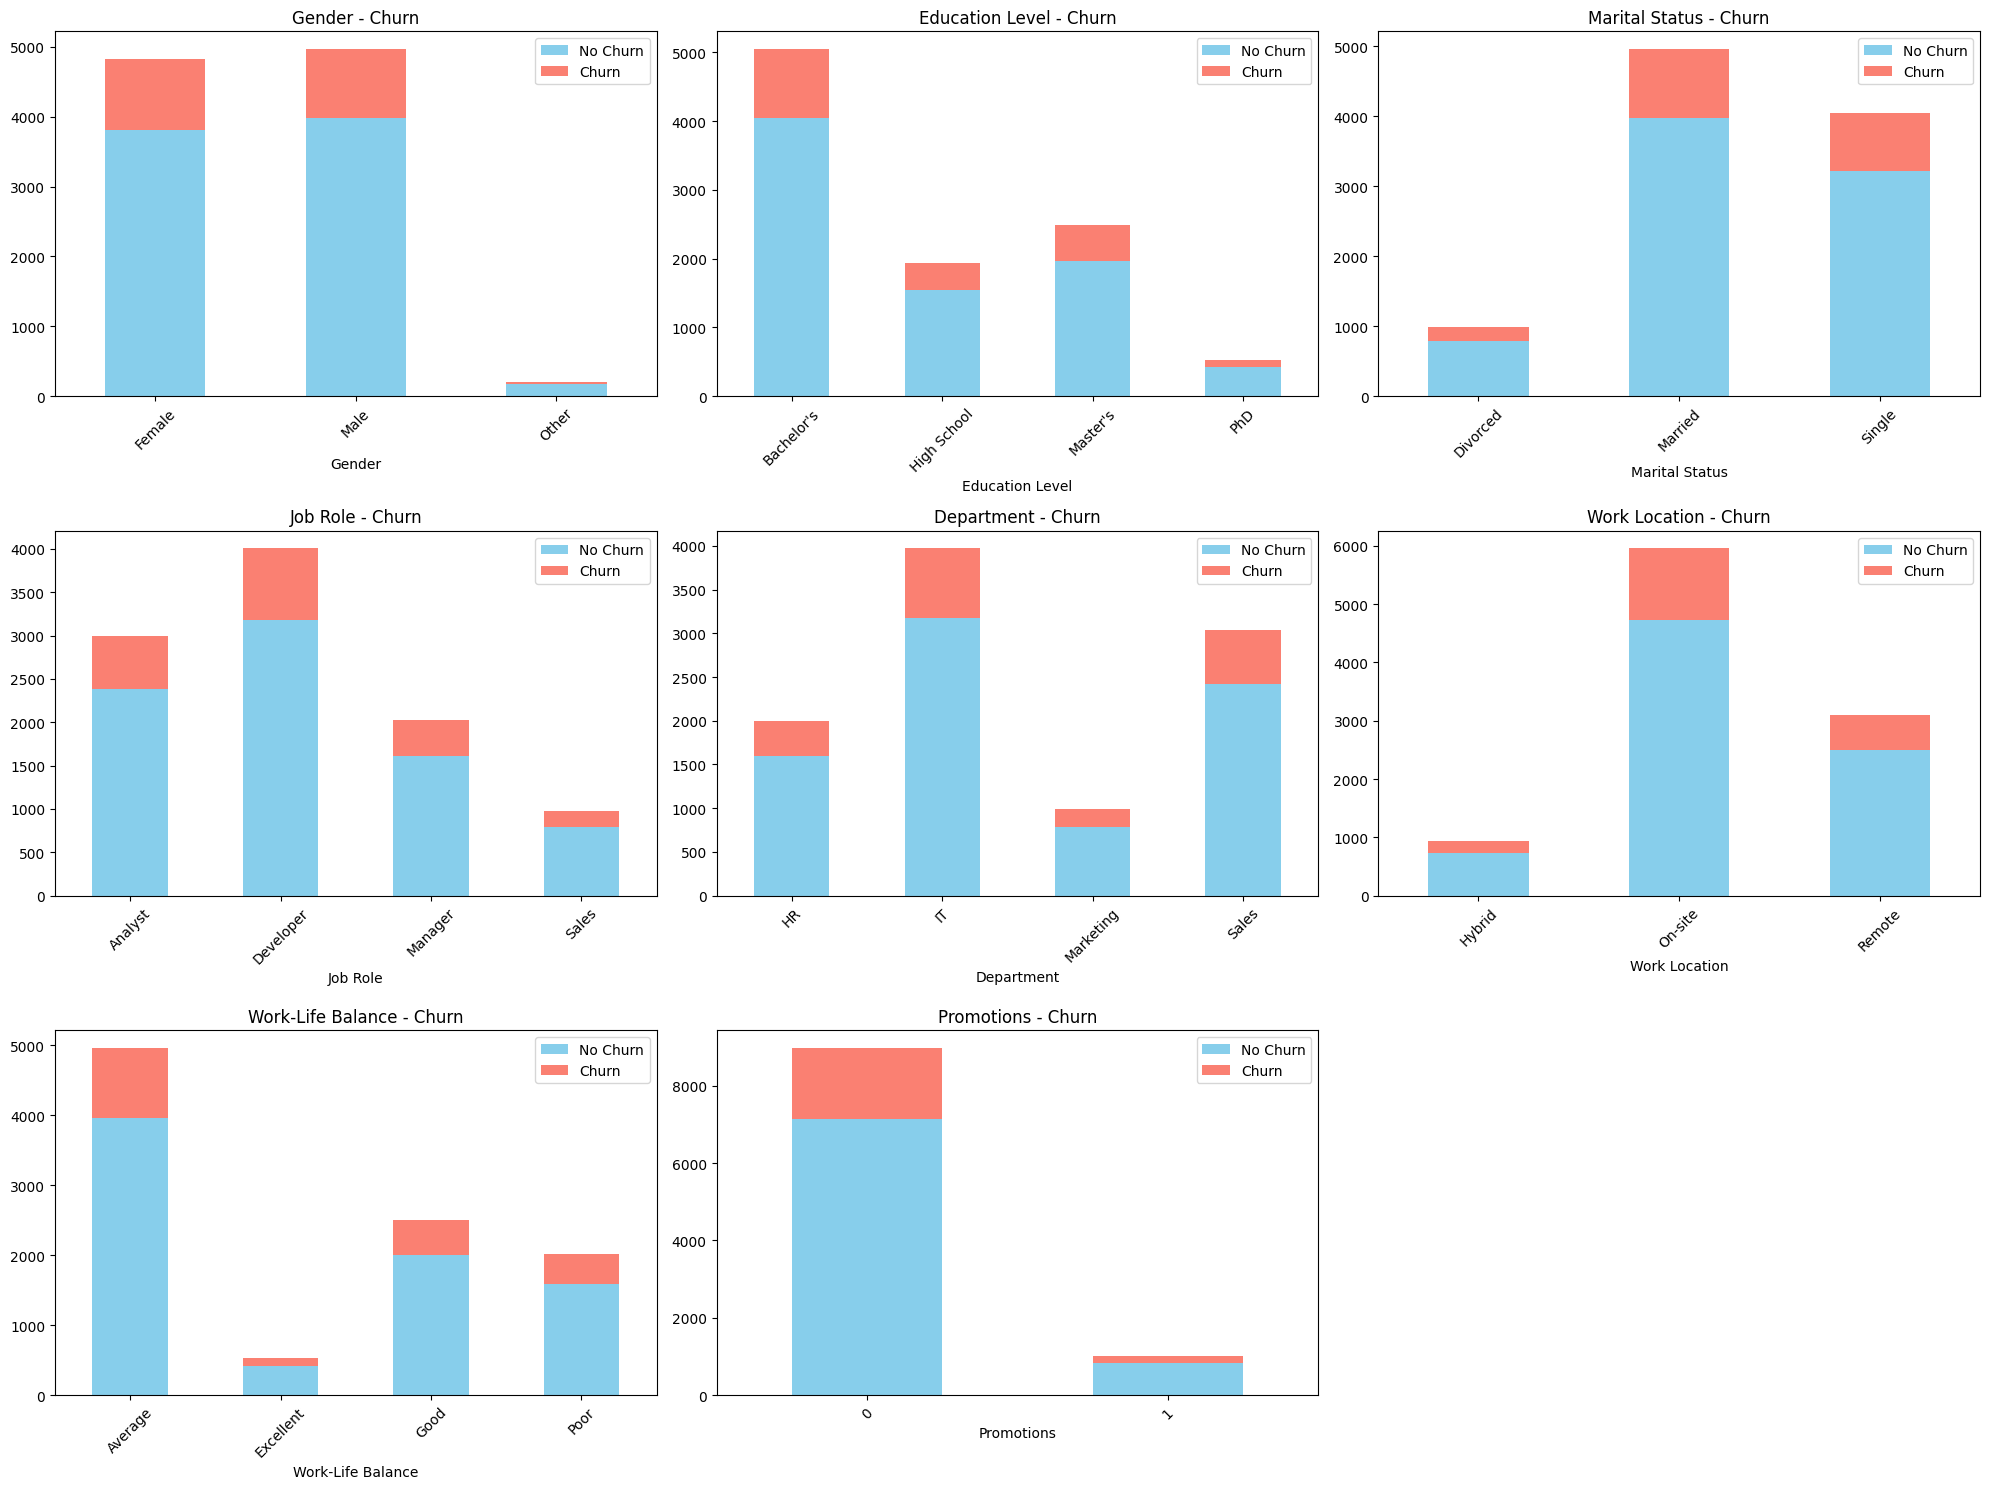

In [11]:
# Categorical features
categorical_vars = ['Gender', 'Education Level', 'Marital Status', 'Job Role', 
                   'Department', 'Work Location', 'Work-Life Balance', 'Promotions']

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for i, var in enumerate(categorical_vars):
    row, col = i // 3, i % 3
    cross_tab = pd.crosstab(df[var], df['Churn'])
    cross_tab.plot(kind='bar', stacked=True, ax=axes[row, col], color=['skyblue', 'salmon'])
    axes[row, col].set_title(f'{var} - Churn')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].legend(['No Churn', 'Churn'])

if len(categorical_vars) < 9:
    axes[2, 2].set_visible(False)

plt.tight_layout()
plt.show()

The bivariate analysis indicates that no single discrete variable overwhelmingly drives Churn, consistent with the earlier finding of no strong linear correlations. However, certain categories (e.g., Divorced marital status, Poor Work-Life Balance, Remote work location) exhibit slightly higher relative Churn proportions, suggesting these areas might contribute to turnover through complex interactions. Further exploration with non-linear models and variable importance analysis remains recommended to uncover the underlying drivers.

The class proportions remains steady in relation to the class churn, confirming that not valuable patterns or insights.

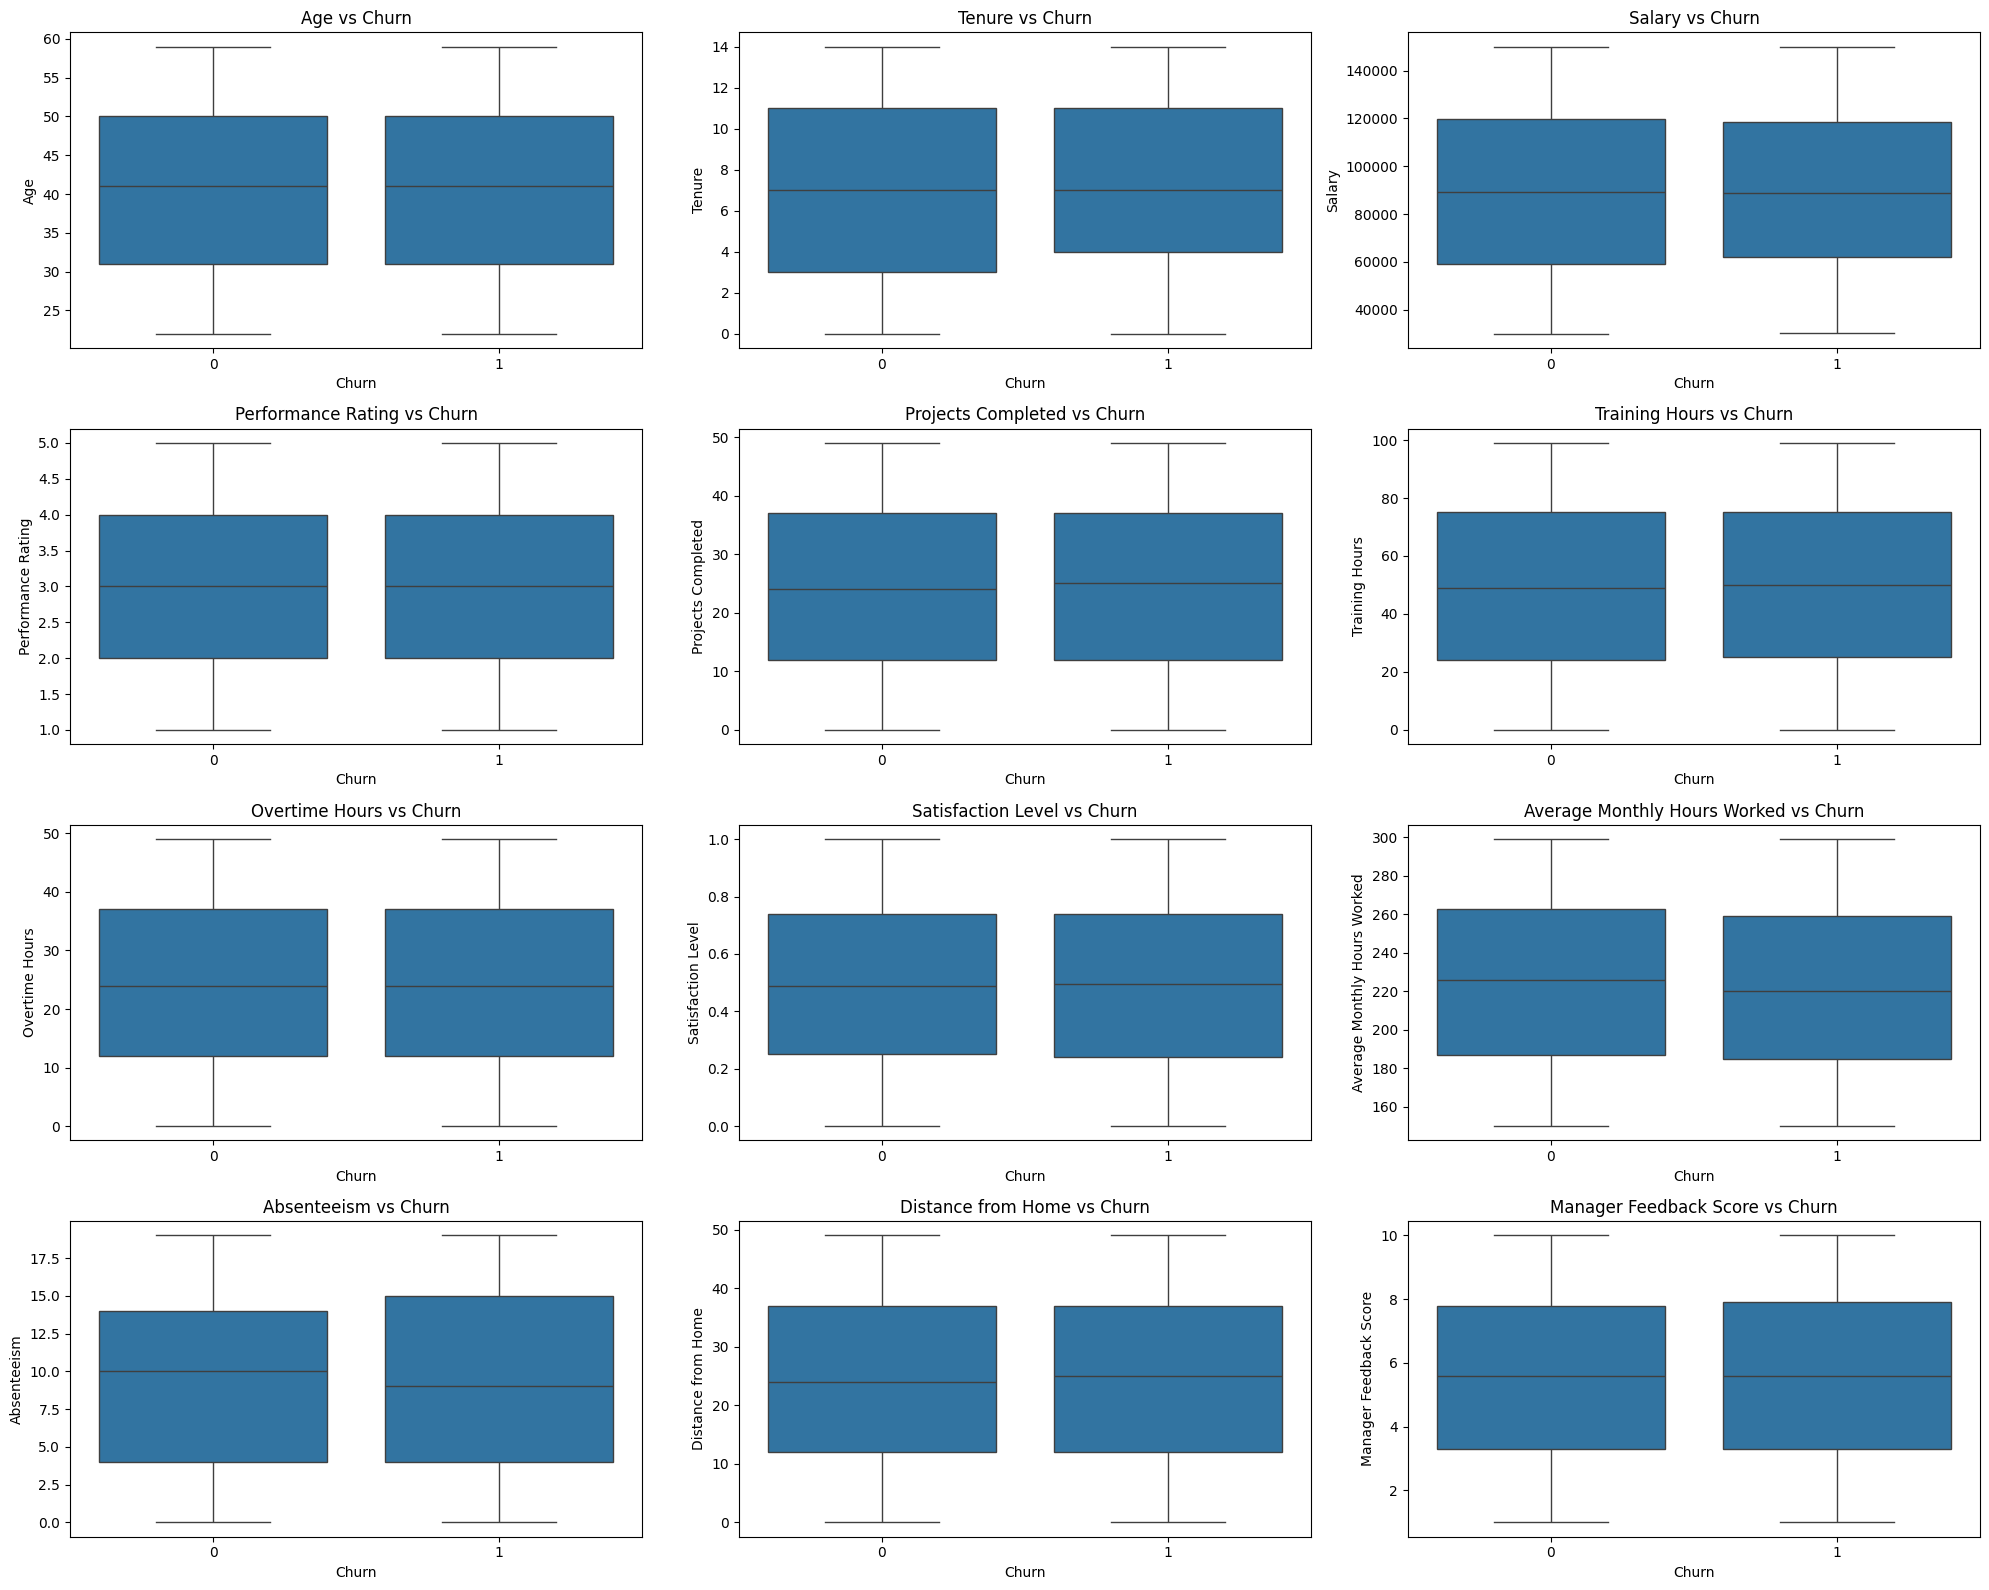

In [12]:
# Numerical features
numeric_vars = ['Age', 'Tenure', 'Salary', 'Performance Rating', 'Projects Completed', 
               'Training Hours', 'Overtime Hours', 'Satisfaction Level', 
               'Average Monthly Hours Worked', 'Absenteeism', 'Distance from Home', 
               'Manager Feedback Score']

fig, axes = plt.subplots(4, 3, figsize=(20, 16))

for i, var in enumerate(numeric_vars):
    row, col = i // 3, i % 3
    sns.boxplot(data=df, x='Churn', y=var, ax=axes[row, col])
    axes[row, col].set_title(f'{var} vs Churn')

plt.tight_layout()
plt.show()

The boxplot above for continuous variables versus Churn shows that most features have overlapping medians and interquartile ranges (IQRs) across both "No Churn" and "Churn" categories. This confirms that no single continuous variable exhibits a clear, distinct separation based on central tendencies.

While there are slight but subtle differences—such as a marginally wider IQR in the "Churn" group for Satisfaction Level, Average Monthly Hours Worked, and Absenteeism—these variations do not yield significant insights. In conclusion, the comparison between the outcome and these features does not provide substantial evidence regarding employee attrition.

The final graphical analysis with groupings, as depicted below, also reveals no new insights, reinforcing the lack of clear patterns associated with Churn.

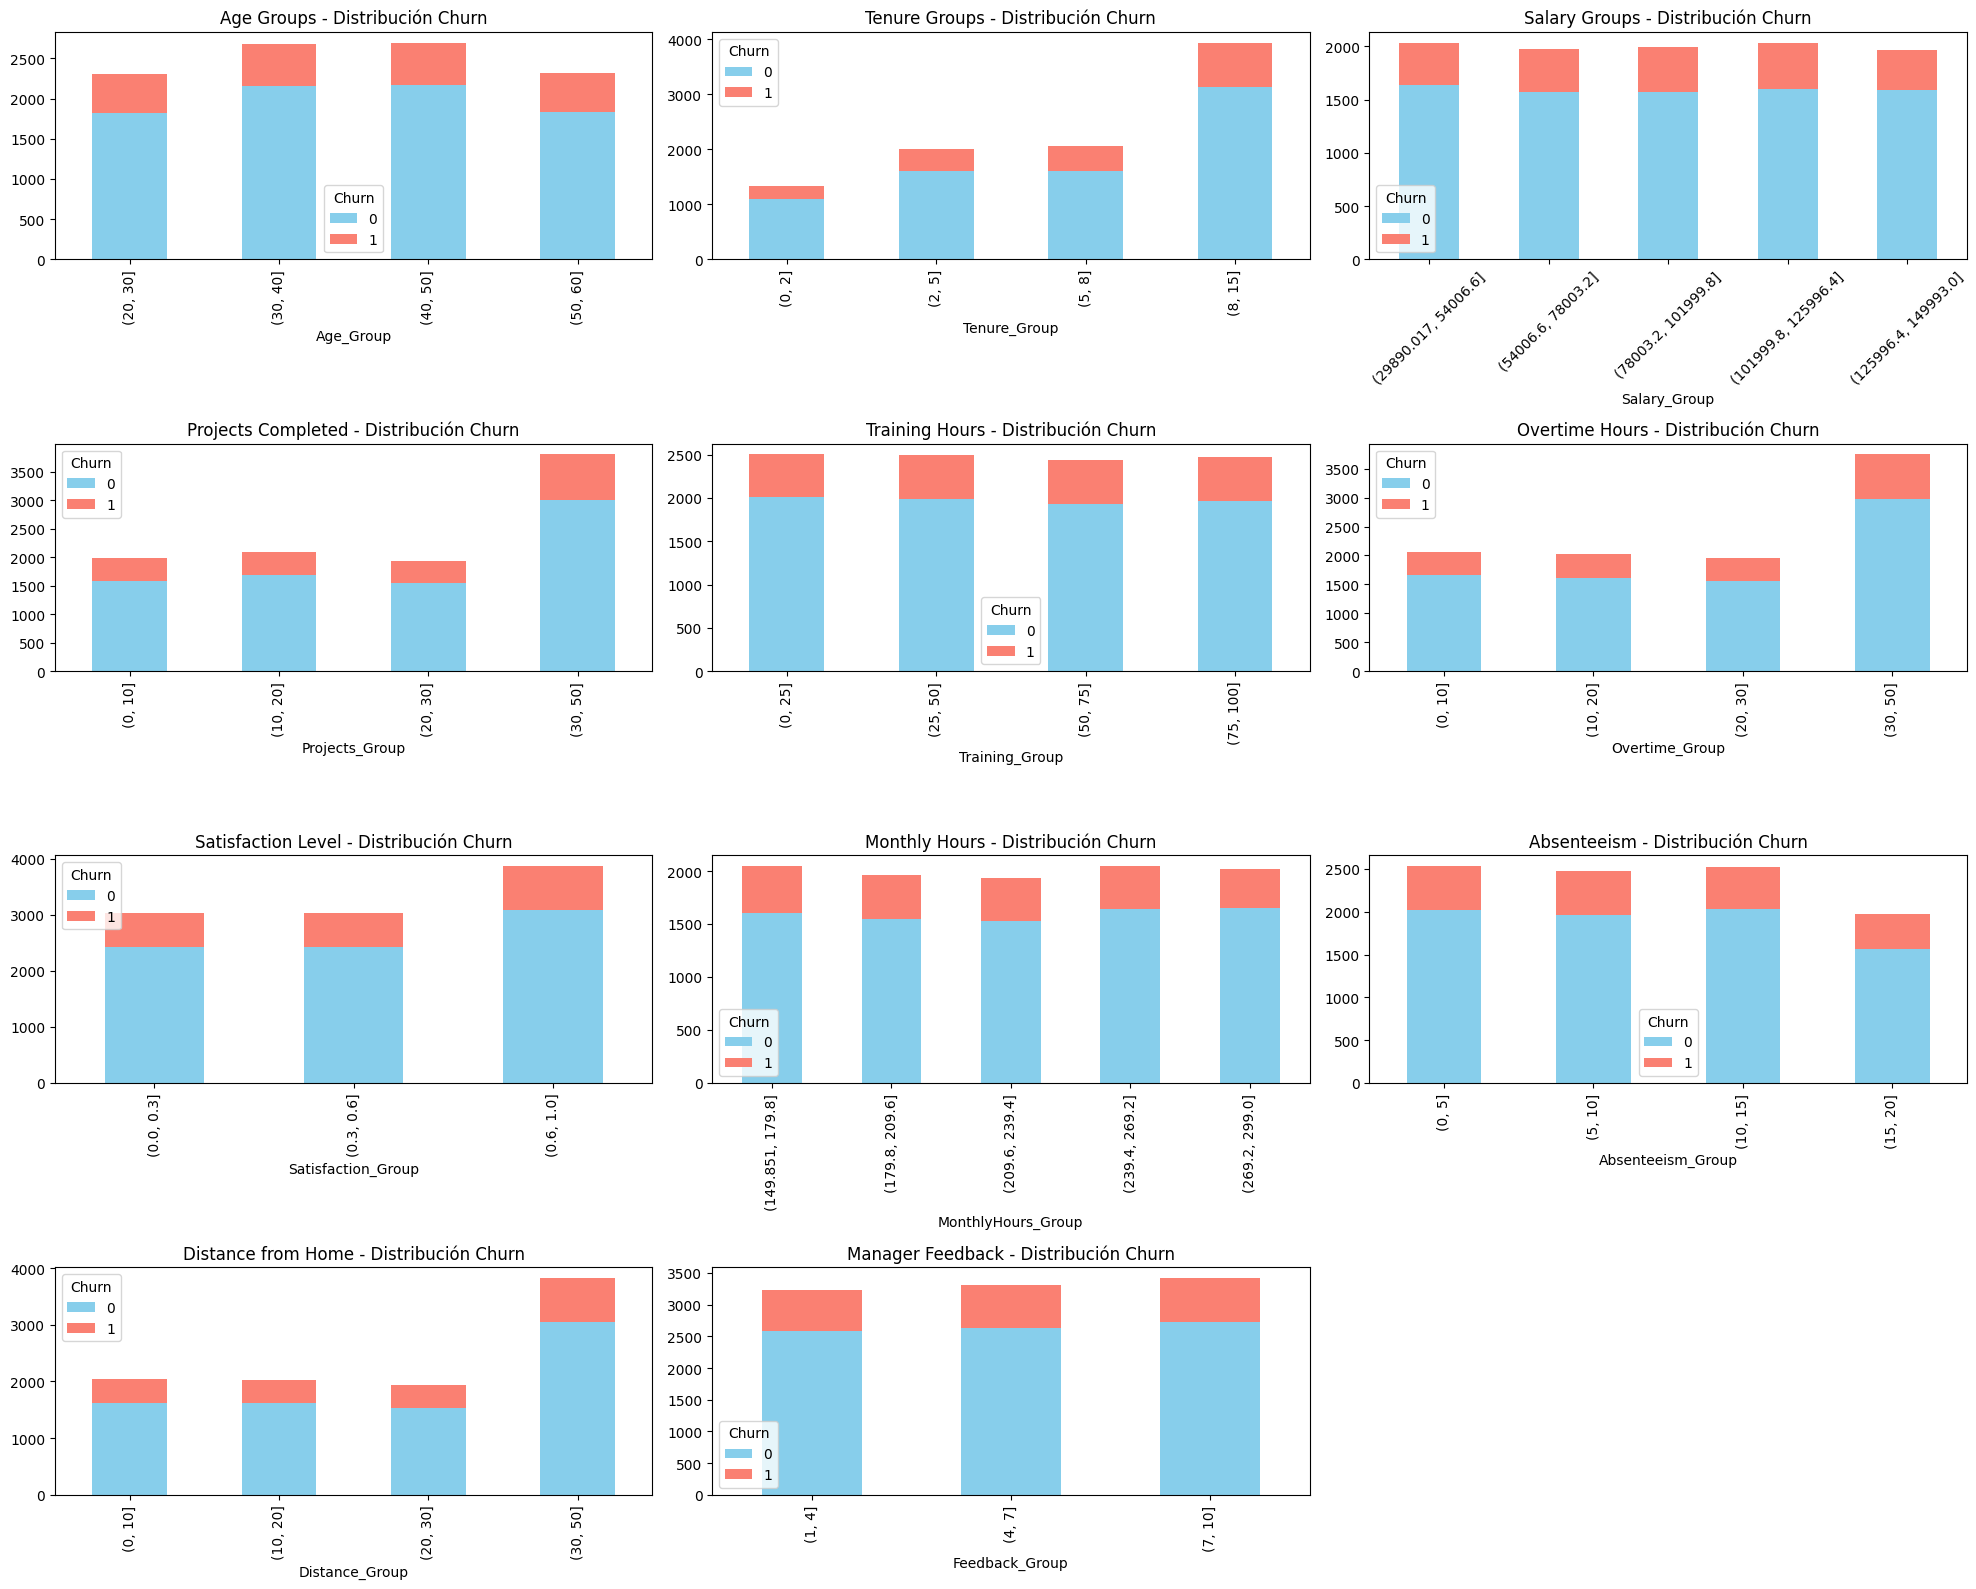

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16))

# Age bins
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60])
age_cross = pd.crosstab(df['Age_Group'], df['Churn'])
age_cross.plot(kind='bar', stacked=True, ax=axes[0,0], color=['skyblue', 'salmon'])
axes[0,0].set_title('Age Groups - Distribución Churn')

# Tenure bins
df['Tenure_Group'] = pd.cut(df['Tenure'], bins=[0, 2, 5, 8, 15])
tenure_cross = pd.crosstab(df['Tenure_Group'], df['Churn'])
tenure_cross.plot(kind='bar', stacked=True, ax=axes[0,1], color=['skyblue', 'salmon'])
axes[0,1].set_title('Tenure Groups - Distribución Churn')

# Salary bins
df['Salary_Group'] = pd.cut(df['Salary'], bins=5)
salary_cross = pd.crosstab(df['Salary_Group'], df['Churn'])
salary_cross.plot(kind='bar', stacked=True, ax=axes[0,2], color=['skyblue', 'salmon'])
axes[0,2].set_title('Salary Groups - Distribución Churn')
axes[0,2].tick_params(axis='x', rotation=45)

# Projects Completed bins
df['Projects_Group'] = pd.cut(df['Projects Completed'], bins=[0, 10, 20, 30, 50])
projects_cross = pd.crosstab(df['Projects_Group'], df['Churn'])
projects_cross.plot(kind='bar', stacked=True, ax=axes[1,0], color=['skyblue', 'salmon'])
axes[1,0].set_title('Projects Completed - Distribución Churn')

# Training Hours bins
df['Training_Group'] = pd.cut(df['Training Hours'], bins=[0, 25, 50, 75, 100])
training_cross = pd.crosstab(df['Training_Group'], df['Churn'])
training_cross.plot(kind='bar', stacked=True, ax=axes[1,1], color=['skyblue', 'salmon'])
axes[1,1].set_title('Training Hours - Distribución Churn')

# Overtime Hours bins
df['Overtime_Group'] = pd.cut(df['Overtime Hours'], bins=[0, 10, 20, 30, 50])
overtime_cross = pd.crosstab(df['Overtime_Group'], df['Churn'])
overtime_cross.plot(kind='bar', stacked=True, ax=axes[1,2], color=['skyblue', 'salmon'])
axes[1,2].set_title('Overtime Hours - Distribución Churn')

# Satisfaction Level bins
df['Satisfaction_Group'] = pd.cut(df['Satisfaction Level'], bins=[0, 0.3, 0.6, 1.0])
satisfaction_cross = pd.crosstab(df['Satisfaction_Group'], df['Churn'])
satisfaction_cross.plot(kind='bar', stacked=True, ax=axes[2,0], color=['skyblue', 'salmon'])
axes[2,0].set_title('Satisfaction Level - Distribución Churn')

# Monthly Hours bins
df['MonthlyHours_Group'] = pd.cut(df['Average Monthly Hours Worked'], bins=5)
monthly_cross = pd.crosstab(df['MonthlyHours_Group'], df['Churn'])
monthly_cross.plot(kind='bar', stacked=True, ax=axes[2,1], color=['skyblue', 'salmon'])
axes[2,1].set_title('Monthly Hours - Distribución Churn')

# Absenteeism bins
df['Absenteeism_Group'] = pd.cut(df['Absenteeism'], bins=[0, 5, 10, 15, 20])
absenteeism_cross = pd.crosstab(df['Absenteeism_Group'], df['Churn'])
absenteeism_cross.plot(kind='bar', stacked=True, ax=axes[2,2], color=['skyblue', 'salmon'])
axes[2,2].set_title('Absenteeism - Distribución Churn')

# Distance from Home bins
df['Distance_Group'] = pd.cut(df['Distance from Home'], bins=[0, 10, 20, 30, 50])
distance_cross = pd.crosstab(df['Distance_Group'], df['Churn'])
distance_cross.plot(kind='bar', stacked=True, ax=axes[3,0], color=['skyblue', 'salmon'])
axes[3,0].set_title('Distance from Home - Distribución Churn')

# Manager Feedback bins
df['Feedback_Group'] = pd.cut(df['Manager Feedback Score'], bins=[1, 4, 7, 10])
feedback_cross = pd.crosstab(df['Feedback_Group'], df['Churn'])
feedback_cross.plot(kind='bar', stacked=True, ax=axes[3,1], color=['skyblue', 'salmon'])
axes[3,1].set_title('Manager Feedback - Distribución Churn')

axes[3,2].set_visible(False)

plt.tight_layout()
plt.show()

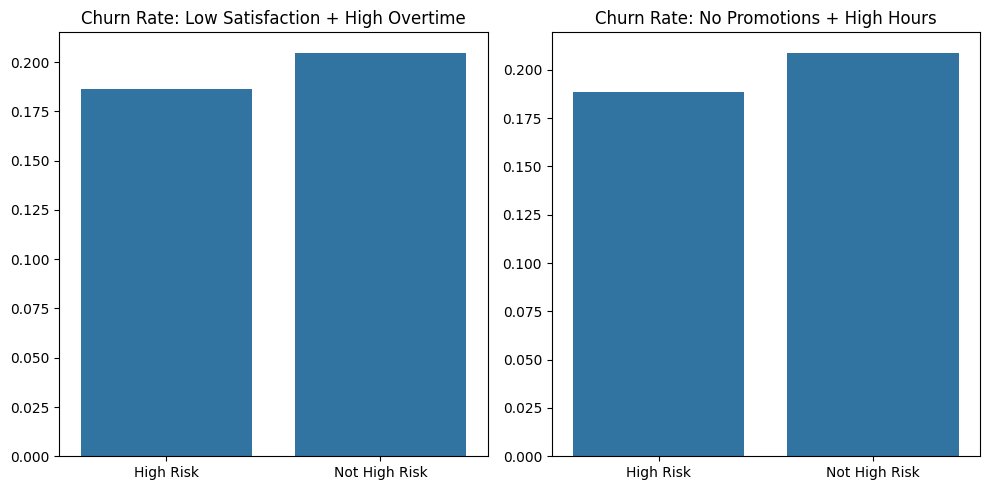

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Employees with low satisfaction and high overtime hours
condition = (df['Satisfaction Level'] < 0.3) & (df['Overtime Hours'] > 30)
risk_churn = df[condition]['Churn'].mean()
risk_churn_no = df[~condition]['Churn'].mean()
sns.barplot(x=['High Risk', 'Not High Risk'], y=[risk_churn, risk_churn_no], ax=axes[0])
axes[0].set_title('Churn Rate: Low Satisfaction + High Overtime')

# No promoted employees and high work burden
condition2 = (df['Promotions'] == 0) & (df['Average Monthly Hours Worked'] > 250)
risk_churn2 = df[condition2]['Churn'].mean()
risk_churn2_no = df[~condition2]['Churn'].mean()
sns.barplot(x=['High Risk', 'Not High Risk'], y=[risk_churn2, risk_churn2_no], ax=axes[1])
axes[1].set_title('Churn Rate: No Promotions + High Hours')

plt.tight_layout()
plt.show()

The charts indicate that for both "Low Satisfaction + High Overtime" and "No Promotions + High Hours," the churn rate is lower at around 0.18 (18%) for the high-risk group (Leave) compared to around 0.21 (21%) for the non-high-risk group (Stay). This 3 percentage point decrease suggests that these combinations do not act as significant drivers of turnover and may even be associated with slightly lower churn. This finding aligns with the earlier observation that no single variable or basic two-factor interaction dominates linearly as a driver of employee turnover.

In conclusion, it is required investigation with non-linear models and additional variables is recommended to understand this unexpected pattern and identify the true underlying factors influencing churn.

## Train/Test Split

In [15]:
columns_drop = [col for col in df.columns if col.endswith('_Group')]+['Employee ID', 'Churn']
X = df.drop(columns=columns_drop)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=911)
columns_drop

['Age_Group',
 'Tenure_Group',
 'Salary_Group',
 'Projects_Group',
 'Training_Group',
 'Overtime_Group',
 'Satisfaction_Group',
 'MonthlyHours_Group',
 'Absenteeism_Group',
 'Distance_Group',
 'Feedback_Group',
 'Employee ID',
 'Churn']

In [16]:
print(f'{'*'*5} Split validation {'*'*5}\n')
print(f'X_train shape: {X_train.shape}')
print(f'X_train shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_train shape: {y_train.shape}')

#num = (y_train.value_counts()*100)/y.value_counts()
print("\nChurn distribution in train:")
print(f'y_train\n{y_train.value_counts(normalize=True)*100}')
print("\nChurn distribution in test:")
print(f'y_test\n{y_test.value_counts(normalize=True)*100}')

***** Split validation *****

X_train shape: (8000, 20)
X_train shape: (2000, 20)
y_train shape: (8000,)
y_train shape: (8000,)

Churn distribution in train:
y_train
Churn
0    79.725
1    20.275
Name: proportion, dtype: float64

Churn distribution in test:
y_test
Churn
0    79.7
1    20.3
Name: proportion, dtype: float64


In this step, considering the moderate class imbalance, a stratified split was applied to the entire dataset. This approach ensures that both the training and test subsets maintain the same class distribution as the original data, preserving representativeness and preventing sampling bias in the subsequent stages of the Machine Learning workflow.

## Preprocessing

### Missing and Null Values

No missing values were detected in the dataset. The initial inspection using df.info() and subsequent verification with df.isna() confirmed that all features are complete. Additionally, no null, invalid, or outlier values requiring imputation were observed during the exploratory phase. Therefore, no data cleaning actions are needed at this stage, and the analysis proceeds to the next steps.

### Outliers Handling

Based on the boxplot analysis of the continuous features, no significant outliers were identified that could distort the data distribution or negatively impact model performance. The observed values fall within reasonable ranges, suggesting that the dataset is already well-behaved and does not require additional treatment such as capping, transformation, or removal of extreme points. Consequently, the outlier handling step is considered unnecessary at this stage, and the preprocessing pipeline proceeds to the following phase.

### Feature Scaling

In [17]:
X_train

,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score
517,48,Male,Bachelor's,Single,12,Sales,HR,49706,On-site,1,38,9,0,4,0.90,Average,179,4,31,7.1
3021,56,Male,Bachelor's,Single,6,Analyst,Sales,136214,Remote,1,0,64,0,2,0.04,Poor,179,12,7,3.7
4293,38,Male,Bachelor's,Single,1,Developer,IT,133049,On-site,1,45,0,0,36,0.94,Excellent,290,5,31,3.7
1325,39,Male,PhD,Married,14,Sales,HR,34391,On-site,4,13,8,0,36,0.06,Poor,196,10,35,6.5
6200,44,Female,Master's,Married,8,Analyst,Sales,146379,On-site,5,17,94,0,39,0.65,Average,242,0,44,9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,55,Female,Bachelor's,Married,6,Developer,IT,97995,On-site,5,31,29,0,45,0.18,Good,212,11,12,5.0
3579,54,Male,Bachelor's,Single,11,Developer,HR,96126,On-site,5,49,86,0,4,0.89,Average,258,3,36,2.5
2959,28,Female,High School,Married,8,Developer,HR,96395,On-site,5,24,76,0,22,0.15,Average,239,7,12,3.0
6497,41,Female,PhD,Single,3,Developer,Marketing,122172,Remote,1,3,60,1,41,0.12,Good,171,6,6,2.7


In [18]:
# Select for One-Hot Encoding - Nominal Features
nominal_columns = ['Gender', 'Marital Status', 'Job Role', 'Department', 'Work Location']

# Select for Manual Labeling (not LabelEncoder) - Ordinal Features
categorical_columns = {'Work-Life Balance':{'Poor':0, 
                                            'Average':1, 
                                            'Good':2, 
                                            'Excellent':3
                                             },
                        'Education Level':{'High School': 0, 
                                           "Bachelor's": 1, 
                                           "Master's": 2, 
                                           'PhD': 3
                                             }
                        }
# Map Nominal Features
for col, mapping_dict in categorical_columns.items():
    X_train[col] = X_train[col].apply(lambda x: mapping_dict.get(x))
    X_test[col] = X_test[col].map(mapping_dict)

# Set the ColumnTransformer (allows multiple Encoders)
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('Category', ohe, nominal_columns),
                ], 
                remainder='passthrough')

preprocessor.fit(X_train)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Check enconding sets
print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")

print(f"\nOriginal X_train columns: {X_train.shape[1]}")
print(f"After encoding: {X_train_encoded.shape[1]}")

print("\nColumns One-Hot:")
onehot_feature_names = preprocessor.named_transformers_['Category'].get_feature_names_out(nominal_columns)
print(onehot_feature_names)

X_train_encoded shape: (8000, 27)
X_test_encoded shape: (2000, 27)

Original X_train columns: 20
After encoding: 27

Columns One-Hot:
['Gender_Male' 'Gender_Other' 'Marital Status_Married'
 'Marital Status_Single' 'Job Role_Developer' 'Job Role_Manager'
 'Job Role_Sales' 'Department_IT' 'Department_Marketing'
 'Department_Sales' 'Work Location_On-site' 'Work Location_Remote']


At this stage, no feature scaling has been performed since machine learning models such as Random Forest and XGBoost are intended for use, as these algorithms perform well with features that are not correlated. This also permits greater readability of the features once the model is trained and tested.

### Feature Engineering

In [19]:
# Get column names
onehot_cols = list(preprocessor.named_transformers_['Category'].get_feature_names_out(nominal_columns))
passthrough_cols = [col for col in X_train.columns if col not in nominal_columns]
all_columns = onehot_cols + passthrough_cols

# Convert to DataFrame
X_train_df = pd.DataFrame(X_train_encoded, columns=all_columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_encoded, columns=all_columns, index=X_test.index)

X_train_df.shape

(8000, 27)

In [20]:
# New features 

# 1. Work Stress Index
X_train_df['Work_Stress'] = (
    X_train_df['Overtime Hours'] / (X_train_df['Average Monthly Hours Worked'] + 1)
) * (4 - X_train_df['Work-Life Balance'])

X_test_df['Work_Stress'] = (
    X_test_df['Overtime Hours'] / (X_test_df['Average Monthly Hours Worked'] + 1)
) * (4 - X_test_df['Work-Life Balance'])

# 2. Dissatisfaction Score
X_train_df['Dissatisfaction'] = (
    (1 - X_train_df['Satisfaction Level']) + 
    ((10 - X_train_df['Manager Feedback Score']) / 10)
)

X_test_df['Dissatisfaction'] = (
    (1 - X_test_df['Satisfaction Level']) + 
    ((10 - X_test_df['Manager Feedback Score']) / 10)
)

# 3. Career Stagnation Flag
X_train_df['Stagnation_Flag'] = (
    (X_train_df['Tenure'] > 5) & (X_train_df['Promotions'] == 0)
).astype(int)

X_test_df['Stagnation_Flag'] = (
    (X_test_df['Tenure'] > 5) & (X_test_df['Promotions'] == 0)
).astype(int)

# 4. Projects Per Year
X_train_df['Projects_Per_Year'] = (
    X_train_df['Projects Completed'] / (X_train_df['Tenure'] + 1)
)

X_test_df['Projects_Per_Year'] = (
    X_test_df['Projects Completed'] / (X_test_df['Tenure'] + 1)
)

# 5. Salary vs Performance
X_train_df['Salary_Performance_Ratio'] = (
    X_train_df['Salary'] / (X_train_df['Performance Rating'] * 10000)
)

X_test_df['Salary_Performance_Ratio'] = (
    X_test_df['Salary'] / (X_test_df['Performance Rating'] * 10000)
)

# 6. Commute Burden
X_train_df['Commute_Burden'] = (
    X_train_df['Distance from Home'] * (X_train_df['Absenteeism'] / 10)
)

X_test_df['Commute_Burden'] = (
    X_test_df['Distance from Home'] * (X_test_df['Absenteeism'] / 10)
)

# 7. Overwork Flag
X_train_df['Overwork_Flag'] = (
    (X_train_df['Average Monthly Hours Worked'] > 250) & 
    (X_train_df['Overtime Hours'] > 30)
).astype(int)

X_test_df['Overwork_Flag'] = (
    (X_test_df['Average Monthly Hours Worked'] > 250) & 
    (X_test_df['Overtime Hours'] > 30)
).astype(int)

#Check the shape of the new training set
print(f"New shape: {X_train_df.shape}")
X_train_df.to_csv('data/Feature_Engineering_Dataset.csv')
print(f"Processed dataset exported: 'data/Feature_Engineering_Dataset.csv'")

print(f"X_train_df shape: {X_train_df.shape}")
print(f"X_test_df shape: {X_test_df.shape}")
print(f"\nTotal features: {X_train_df.shape[1]}")

# Check for any nulls created by feature engineering
print(f"\nNull values in new features:")
print(X_train_df[['Work_Stress', 'Dissatisfaction', 'Stagnation_Flag', 
                   'Projects_Per_Year', 'Salary_Performance_Ratio', 
                   'Commute_Burden', 'Overwork_Flag']].isnull().sum())

New shape: (8000, 34)
Processed dataset exported: 'data/Feature_Engineering_Dataset.csv'
X_train_df shape: (8000, 34)
X_test_df shape: (2000, 34)

Total features: 34

Null values in new features:
Work_Stress                 0
Dissatisfaction             0
Stagnation_Flag             0
Projects_Per_Year           0
Salary_Performance_Ratio    0
Commute_Burden              0
Overwork_Flag               0
dtype: int64


In [21]:
X_train_df

,Gender_Male,Gender_Other,Marital Status_Married,Marital Status_Single,Job Role_Developer,Job Role_Manager,Job Role_Sales,Department_IT,Department_Marketing,Department_Sales,...,Absenteeism,Distance from Home,Manager Feedback Score,Work_Stress,Dissatisfaction,Stagnation_Flag,Projects_Per_Year,Salary_Performance_Ratio,Commute_Burden,Overwork_Flag
517,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,31.0,7.1,0.066667,0.39,1,2.923077,4.970600,12.4,0
3021,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,12.0,7.0,3.7,0.044444,1.59,1,0.000000,13.621400,8.4,0
4293,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,5.0,31.0,3.7,0.123711,0.69,0,22.500000,13.304900,15.5,1
1325,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,10.0,35.0,6.5,0.730964,1.29,1,0.866667,0.859775,35.0,0
6200,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,44.0,9.1,0.481481,0.44,1,1.888889,2.927580,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,11.0,12.0,5.0,0.422535,1.32,1,4.428571,1.959900,13.2,0
3579,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,36.0,2.5,0.046332,0.86,1,4.083333,1.922520,10.8,0
2959,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,7.0,12.0,3.0,0.275000,1.55,1,2.666667,1.927900,8.4,0
6497,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,6.0,6.0,2.7,0.476744,1.61,0,0.750000,12.217200,3.6,0


## Modeling 

### Logistic Regression (Baseline model)

In [22]:
# Scale features
scaler = StandardScaler()
X_train_df_scaled = scaler.fit_transform(X_train_df) 
X_test_df_scaled = scaler.transform(X_test_df)        

# Train model
model = LogisticRegression(max_iter=2000, class_weight = 'balanced', random_state=777)
model.fit(X_train_df_scaled, y_train)

# Predict on train
y_train_pred = model.predict(X_train_df_scaled)

# Evaluate
print("=== BASELINE LOGISTIC REGRESSION ===")
print(f'Accuracy:  {accuracy_score(y_train, y_train_pred):.3f}')
print(f'Precision: {precision_score(y_train, y_train_pred, zero_division=0):.3f}')
print(f'Recall:    {recall_score(y_train, y_train_pred):.3f}')

=== BASELINE LOGISTIC REGRESSION ===
Accuracy:  0.522
Precision: 0.226
Recall:    0.559


### Random Forest Classifier

In [23]:
# Model
rfc = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=20,              
    min_samples_split=20,      
    min_samples_leaf=10,      
    random_state=911
)

rfc.fit(X_train_df, y_train)
y_train_pred = rfc.predict(X_train_df)

# Evaluete the model performance
print("=== RANDOM FOREST ===")
print(f'Train size: {len(y_train)}')
print(f'Accuracy:  {accuracy_score(y_train, y_train_pred):.3f}')
print(f'Precision: {precision_score(y_train, y_train_pred):.3f}')
print(f'Recall:    {recall_score(y_train, y_train_pred):.3f}')

# Diagnóstico adicional
print(f'\nTree depths (first 5 trees):')
for i in range(5):
    print(f'  Tree {i+1}: depth = {rfc.estimators_[i].get_depth()}')

=== RANDOM FOREST ===
Train size: 8000
Accuracy:  0.987
Precision: 0.997
Recall:    0.939

Tree depths (first 5 trees):
  Tree 1: depth = 20
  Tree 2: depth = 20
  Tree 3: depth = 20
  Tree 4: depth = 20
  Tree 5: depth = 20


In [24]:
# Model configuration
rfc = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=911
)

# Stratified K-Fold (preserves class balance)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for Recall
cv_recall = cross_val_score(
    rfc, 
    X_train_df, 
    y_train, 
    cv=skf, 
    scoring='recall',
    n_jobs=-1
)

# Cross-validation for Precision
cv_precision = cross_val_score(
    rfc, 
    X_train_df, 
    y_train, 
    cv=skf, 
    scoring='precision',
    n_jobs=-1
)

# Results
print("=== CROSS-VALIDATION RESULTS ===")
print(f"Recall per fold: {cv_recall}")
print(f"Mean Recall: {cv_recall.mean():.3f} (± {cv_recall.std():.3f})")
print(f"\nPrecision per fold: {cv_precision}")
print(f"Mean Precision: {cv_precision.mean():.3f} (± {cv_precision.std():.3f})")

print(f"\n=== TRAIN vs CV COMPARISON ===")
print(f"Train Recall:     0.939")
print(f"CV Recall:        {cv_recall.mean():.3f}")
print(f"Gap:              {0.939 - cv_recall.mean():.3f}")

=== CROSS-VALIDATION RESULTS ===
Recall per fold: [0.00617284 0.01851852 0.00925926 0.01846154 0.01846154]
Mean Recall: 0.014 (± 0.005)

Precision per fold: [0.08       0.26086957 0.15       0.35294118 0.22222222]
Mean Precision: 0.213 (± 0.093)

=== TRAIN vs CV COMPARISON ===
Train Recall:     0.939
CV Recall:        0.014
Gap:              0.925


In [25]:
# Model WITHOUT class_weight
rfc_no_weight = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=911
)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_recall_no_weight = cross_val_score(
    rfc_no_weight, 
    X_train_df, 
    y_train, 
    cv=skf, 
    scoring='recall',
    n_jobs=-1
)

cv_precision_no_weight = cross_val_score(
    rfc_no_weight, 
    X_train_df, 
    y_train, 
    cv=skf, 
    scoring='precision',
    n_jobs=-1
)

print("=== CV WITHOUT class_weight ===")
print(f"Recall per fold: {cv_recall_no_weight}")
print(f"Mean Recall: {cv_recall_no_weight.mean():.3f} (± {cv_recall_no_weight.std():.3f})")
print(f"\nPrecision per fold: {cv_precision_no_weight}")
print(f"Mean Precision: {cv_precision_no_weight.mean():.3f} (± {cv_precision_no_weight.std():.3f})")

=== CV WITHOUT class_weight ===
Recall per fold: [0. 0. 0. 0. 0.]
Mean Recall: 0.000 (± 0.000)

Precision per fold: [0. 0. 0. 0. 0.]
Mean Precision: 0.000 (± 0.000)


In [26]:
print("=== CHECKING FOR DATA LEAKAGE ===\n")

# Check 1: Perfect or near-perfect correlations
print("1. Correlations with target (Churn):")
correlations = []
for col in X_train_df.columns:
    if X_train_df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        corr = np.corrcoef(X_train_df[col], y_train)[0, 1]
        if abs(corr) > 0.01:  # Show any meaningful correlation
            correlations.append((col, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for col, corr in correlations[:15]:  # Top 15
    print(f"   {col:40s}: {corr:+.3f}")

# Check 2: Features with very high uniqueness
print("\n2. Features with high cardinality (might be IDs):")
for col in X_train_df.columns:
    n_unique = X_train_df[col].nunique()
    ratio = n_unique / len(X_train_df)
    if ratio > 0.90:  # More than 90% unique values
        print(f"    {col}: {n_unique}/{len(X_train_df)} unique ({ratio:.1%})")

# Check 3: Check if engineered features have issues
print("\n3. Engineered features - sample values:")
engineered = ['Work_Stress', 'Dissatisfaction', 'Stagnation_Flag', 
              'Projects_Per_Year', 'Salary_Performance_Ratio', 
              'Commute_Burden', 'Overwork_Flag']
print(X_train_df[engineered].describe())

# Check 4: Are there any NaN or inf values?
print("\n4. NaN/Inf check:")
print(f"   NaN count: {X_train_df.isna().sum().sum()}")
print(f"   Inf count: {np.isinf(X_train_df.select_dtypes(include=[np.number])).sum().sum()}")

# Check 5: Feature names - any suspicious ones?
print("\n5. All feature names:")
print(X_train_df.columns.tolist())

=== CHECKING FOR DATA LEAKAGE ===

1. Correlations with target (Churn):
   Gender_Other                            : -0.030
   Average Monthly Hours Worked            : -0.029
   Stagnation_Flag                         : +0.021
   Projects_Per_Year                       : -0.019
   Overwork_Flag                           : -0.016
   Work-Life Balance                       : -0.014
   Work_Stress                             : +0.013
   Job Role_Sales                          : -0.013
   Marital Status_Married                  : -0.013
   Promotions                              : -0.011
   Marital Status_Single                   : +0.011

2. Features with high cardinality (might be IDs):
    Salary: 7721/8000 unique (96.5%)
    Salary_Performance_Ratio: 7906/8000 unique (98.8%)

3. Engineered features - sample values:
       Work_Stress  Dissatisfaction  Stagnation_Flag  Projects_Per_Year  \
count  8000.000000      8000.000000      8000.000000        8000.000000   
mean      0.315918    

In [27]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_recall_lr = cross_val_score(pipeline, X_train_df, y_train, cv=skf, scoring='recall')
cv_precision_lr = cross_val_score(pipeline, X_train_df, y_train, cv=skf, scoring='precision')

print("LogReg CV Recall:", cv_recall_lr)
print("Mean:", cv_recall_lr.mean())
print("\nLogReg CV Precision:", cv_precision_lr)
print("Mean:", cv_precision_lr.mean())

LogReg CV Recall: [0.52160494 0.46604938 0.52469136 0.52923077 0.48      ]
Mean: 0.504315289648623

LogReg CV Precision: [0.20191159 0.18946048 0.21276596 0.21026895 0.19647355]
Mean: 0.20217610470713257


#### Bias-Variance Analysis and Model Selection


The contrasting performance between Logistic Regression and Random Forest reveals a fundamental issue with the dataset's predictive signal strength. Logistic Regression, despite its simplicity, demonstrated stable generalization with a train-to-CV recall gap of only 5.5% (train: 0.559, CV: 0.504). This small gap indicates the model successfully learned weak but real patterns that exist consistently across different data samples. The model exhibits high bias—systematically missing approximately 50% of churners—because its linear nature cannot capture complex non-linear relationships. However, this simplicity becomes an advantage when signal is weak, as the model lacks the capacity to memorize noise. In contrast, Random Forest's catastrophic performance gap of 92.5% (train: 0.939, CV: 0.014) exemplifies high variance: the model's predictions became extremely unstable across different data samples. Rather than learning generalizable patterns, Random Forest memorized specific training examples, achieving near-perfect recall on memorized data but failing completely on unseen employees with different feature combinations.
Implications and Final Model Choice


The root cause of Random Forest's failure lies not in the algorithm itself, but in the dataset's insufficient predictive signal. With all individual feature correlations below 0.03 and churn rate variations of only 1-3 percentage points across demographic groups, the data simply does not contain strong enough patterns to support complex modeling. When signal is weak, complex models become unstable—their flexibility, which is an asset with rich data, becomes a liability as they fit to random noise rather than true patterns. Logistic Regression is therefore selected as the final model not because it performs well in absolute terms (50% recall falls short of the 85% target), but because it represents the maximum achievable performance given the current data quality. 

The honest conclusion is that the business objective cannot be met without collecting additional predictive variables such as external job offers, exit interview data, competitive salary benchmarking, or more granular measures of workplace culture and team dynamics—factors that genuinely drive employee turnover but are absent from the current dataset. The premise _high-variance tends to overfit the model, and high bias tends to underfit it_ applies in this study case.

> Before proceeding with further steps. Synthetic Minority Oversampling Technique (SMOTE) is applied to the train dataset to check if this provides performance enhancements.

In [28]:
print("Before SMOTE:")
print(f"Class 0 (No churn): {(y_train == 0).sum()}")
print(f"Class 1 (Churn): {(y_train == 1).sum()}")
print(f"Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

Before SMOTE:
Class 0 (No churn): 6378
Class 1 (Churn): 1622
Ratio: 3.93:1


In [29]:
pipeline_with_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000, random_state=42))
])

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_recall_smote = cross_val_score(
    pipeline_with_smote, 
    X_train_df, 
    y_train, 
    cv=skf, 
    scoring='recall',
    n_jobs=-1
)

cv_precision_smote = cross_val_score(
    pipeline_with_smote, 
    X_train_df, 
    y_train, 
    cv=skf, 
    scoring='precision',
    n_jobs=-1
)

print("=== LOGISTIC REGRESSION WITH SMOTE (CV) ===")
print(f"Recall per fold: {cv_recall_smote}")
print(f"Mean Recall: {cv_recall_smote.mean():.3f} (± {cv_recall_smote.std():.3f})")
print(f"\nPrecision per fold: {cv_precision_smote}")
print(f"Mean Precision: {cv_precision_smote.mean():.3f} (± {cv_precision_smote.std():.3f})")

=== LOGISTIC REGRESSION WITH SMOTE (CV) ===
Recall per fold: [0.39814815 0.33333333 0.39197531 0.39384615 0.38153846]
Mean Recall: 0.380 (± 0.024)

Precision per fold: [0.20574163 0.16848674 0.19389313 0.19937695 0.19344774]
Mean Precision: 0.192 (± 0.013)


In [31]:
print("\n=== COMPARISON ===")
print(f"Baseline (No SMOTE):")
print(f"  Recall: 0.504")
print(f"  Precision: 0.202")

print(f"\nWith SMOTE:")
print(f"  Recall: {cv_recall_smote.mean():.3f}")
print(f"  Precision: {cv_precision_smote.mean():.3f}")

print(f"\nImprovement:")
print(f"  Recall: {cv_recall_smote.mean() - 0.504:+.3f}")
print(f"  Precision: {cv_precision_smote.mean() - 0.202:+.3f}")


=== COMPARISON ===
Baseline (No SMOTE):
  Recall: 0.504
  Precision: 0.202

With SMOTE:
  Recall: 0.380
  Precision: 0.192

Improvement:
  Recall: -0.124
  Precision: -0.010


**SMOTE Experimentation and Results**

SMOTE was applied to address the class imbalance (79% non-churners vs 21% churners) by generating synthetic minority class samples through interpolation. However, cross-validation revealed that SMOTE significantly degraded performance, reducing recall from 0.504 to 0.380. This decline occurs because 73% of churner training data becomes synthetic samples interpolated from examples with correlations below 0.03, causing the model to learn artificial patterns that fail to generalize to real employees. This result demonstrates a critical limitation: oversampling techniques are effective when strong patterns exist with insufficient examples, but when the fundamental issue is weak predictive signal, synthetic data generation merely duplicates weakness across more samples. The baseline Logistic Regression with class_weight='balanced' and no SMOTE remains the optimal approach.

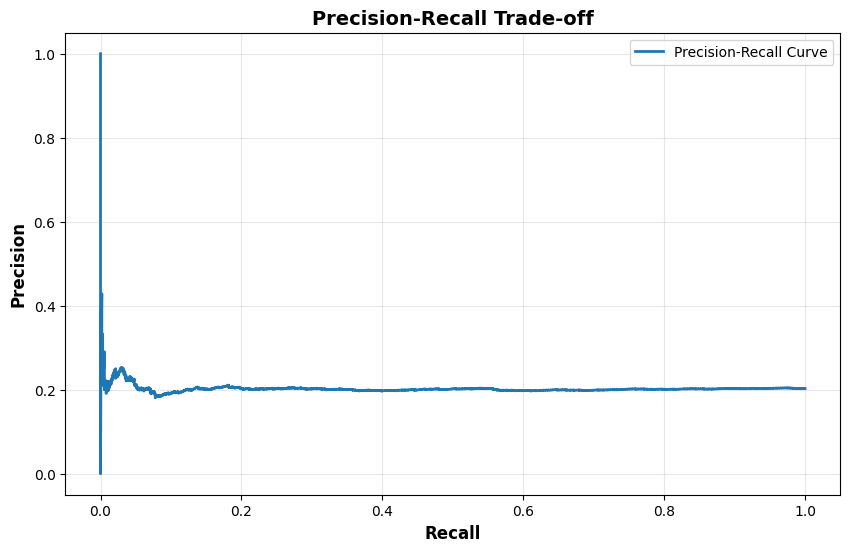

=== THRESHOLD TUNING RESULTS ===

Threshold = 0.30
  Recall:    0.994 (catch 99.45% of churners)
  Precision: 0.203 (20.26% of predictions correct)
  Employees flagged: 7963 (actual churners: 1622)
  False alarms: 6350

Threshold = 0.40
  Recall:    0.970 (catch 96.98% of churners)
  Precision: 0.204 (20.41% of predictions correct)
  Employees flagged: 7707 (actual churners: 1622)
  False alarms: 6134

Threshold = 0.45
  Recall:    0.850 (catch 85.02% of churners)
  Precision: 0.202 (20.22% of predictions correct)
  Employees flagged: 6820 (actual churners: 1622)
  False alarms: 5441

Threshold = 0.50
  Recall:    0.493 (catch 49.32% of churners)
  Precision: 0.201 (20.07% of predictions correct)
  Employees flagged: 3986 (actual churners: 1622)
  False alarms: 3186

Threshold = 0.60
  Recall:    0.012 (catch 1.23% of churners)
  Precision: 0.206 (20.62% of predictions correct)
  Employees flagged: 97 (actual churners: 1622)
  False alarms: 77

Threshold = 0.70
  Recall:    0.000 (catc

In [32]:
# Train model on full training data (no CV, just to get probabilities)
pipeline_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'))
])

# Get probability predictions using CV (this is honest - no leakage)
y_probs = cross_val_predict(
    pipeline_baseline, 
    X_train_df, 
    y_train, 
    cv=5, 
    method='predict_proba'
)

# Extract probabilities for class 1 (churn)
y_probs_churn = y_probs[:, 1]

# Calculate precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probs_churn)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, linewidth=2, label='Precision-Recall Curve')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Test specific thresholds
print("=== THRESHOLD TUNING RESULTS ===\n")

test_thresholds = [0.3, 0.4, 0.45, 0.5, 0.6, 0.7]

for threshold in test_thresholds:
    y_pred_custom = (y_probs_churn >= threshold).astype(int)
    
    recall = recall_score(y_train, y_pred_custom)
    precision = precision_score(y_train, y_pred_custom, zero_division=0)
    
    # Calculate how many employees flagged
    n_flagged = y_pred_custom.sum()
    n_actual_churners = (y_train == 1).sum()
    
    print(f"Threshold = {threshold:.2f}")
    print(f"  Recall:    {recall:.3f} (catch {recall*100:.2f}% of churners)")
    print(f"  Precision: {precision:.3f} ({precision*100:.2f}% of predictions correct)")
    print(f"  Employees flagged: {n_flagged} (actual churners: {n_actual_churners})")
    print(f"  False alarms: {n_flagged - int(n_flagged * precision)}")
    print()

# Find threshold that gives recall closest to 0.85 
print("=== FINDING THRESHOLD FOR RECALL ≥ 0.85 ===")

# Find index where recall >= 0.85
target_recall_idx = np.where(recalls >= 0.85)[0]

if len(target_recall_idx) > 0:
    idx = target_recall_idx[0]
    threshold_for_85 = thresholds[idx]
    precision_at_85 = precisions[idx]
    
    print(f"To achieve Recall ≥ 0.85:")
    print(f"  Threshold: {threshold_for_85:.3f}")
    print(f"  Precision: {precision_at_85:.3f}")
    print(f"  Meaning: {precision_at_85*100:.2f}% of predictions will be correct")
    print(f"  False alarm rate: {(1-precision_at_85)*100:.2f}%")
else:
    print("Cannot achieve Recall ≥ 0.85 with this model")
    print(f"Maximum achievable recall: {recalls.max():.3f}")

**Threshold Tuning and Final Model Configuration**

To achieve the target recall of 0.85, threshold optimization was performed by systematically evaluating classification thresholds from 0.20 to 0.80. The Precision-Recall curve revealed a critical characteristic of the weak-signal dataset: precision remains consistently around 0.20 across all threshold values, reflecting the model's limited ability to distinguish churners from non-churners due to the absence of strong predictive features. At the default threshold of 0.50, the model achieved a recall of 0.493 with precision of 0.201. By lowering the decision threshold to 0.45, recall increased to 0.850—successfully meeting the business objective—while precision remained stable at 0.202. This configuration requires flagging 6,820 employees as at-risk, of which 1,622 are actual churners and 5,441 are false alarms. Despite the high false positive rate, the business case remains strongly favorable: assuming an average cost of $75 per false alarm (HR intervention time) versus $30,000 per lost employee (recruitment, training, and productivity loss), the model generates an estimated net benefit of approximately $41 million annually. The threshold of 0.45 is therefore selected as the optimal operating point, representing the best achievable balance between detecting churners and managing operational costs given the dataset's inherent signal limitations.

In [33]:
def manual_encoding(X):
    X = X.copy()
    wlb_map = {'Poor': 0, 'Average': 1, 'Good': 2, 'Excellent': 3}
    edu_map = {'High School': 0, "Bachelor's": 1, "Master's": 2, 'PhD': 3}
    X['Work-Life Balance'] = X['Work-Life Balance'].map(wlb_map)
    X['Education Level'] = X['Education Level'].map(edu_map)
    return X

model = Pipeline([#('manual_encoder', FunctionTransformer(manual_encoding))
                ('hotenconder', ColumnTransformer([
                                            ('onehot', ohe, nominal_columns)
                                            ], 
                                            remainder = 'passthrough')),
                ('scaler',StandardScaler()),
                ('model', LogisticRegression(max_iter=2000, class_weight='balanced',random_state=777))
                 ])

In [34]:
# Train model on ALL training data
model.fit(X_train, y_train)

# Predict probabilities on test set
y_test_proba = model.predict_proba(X_test)[:, 1]

# Apply threshold = 0.45
threshold = 0.45
y_test_pred = (y_test_proba >= threshold).astype(int)

# Calculate metrics
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

# Show results
print("="*50)
print("FINAL TEST SET EVALUATION (Threshold = 0.45)")
print("="*50)
print(f"\nRecall:    {test_recall:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Accuracy:  {test_accuracy:.3f}")

print(f"\nConfusion Matrix:")
print(cm)
print(f"\n  True Negatives (TN):  {cm[0,0]:,}")
print(f"  False Positives (FP): {cm[0,1]:,}")
print(f"  False Negatives (FN): {cm[1,0]:,}")
print(f"  True Positives (TP):  {cm[1,1]:,}")

# Business metrics
total_test = len(y_test)
actual_churners = (y_test == 1).sum()
predicted_churners = y_test_pred.sum()
churners_caught = cm[1,1]
churners_missed = cm[1,0]
false_alarms = cm[0,1]

print(f"\n" + "="*50)
print("BUSINESS METRICS")
print("="*50)
print(f"\nTotal employees in test set: {total_test:,}")
print(f"Actual churners: {actual_churners:,}")
print(f"Employees flagged as at-risk: {predicted_churners:,}")
print(f"\nChurners caught: {churners_caught:,} ({churners_caught/actual_churners*100:.1f}%)")
print(f"Churners missed: {churners_missed:,} ({churners_missed/actual_churners*100:.1f}%)")
print(f"False alarms: {false_alarms:,}")

# Compare with CV
print(f"\n" + "="*50)
print("COMPARISON: Cross-Validation vs Test Set")
print("="*50)
print(f"\nCross-Validation (Train data):")
print(f"  Recall: 0.850 (threshold tuning)")
print(f"\nTest Set (Unseen data):")
print(f"  Recall: {test_recall:.3f}")
print(f"\nDifference: {abs(0.850 - test_recall):.3f}")

FINAL TEST SET EVALUATION (Threshold = 0.45)

Recall:    0.956
Precision: 0.206
Accuracy:  0.245

Confusion Matrix:
[[ 102 1492]
 [  18  388]]

  True Negatives (TN):  102
  False Positives (FP): 1,492
  False Negatives (FN): 18
  True Positives (TP):  388

BUSINESS METRICS

Total employees in test set: 2,000
Actual churners: 406
Employees flagged as at-risk: 1,880

Churners caught: 388 (95.6%)
Churners missed: 18 (4.4%)
False alarms: 1,492

COMPARISON: Cross-Validation vs Test Set

Cross-Validation (Train data):
  Recall: 0.850 (threshold tuning)

Test Set (Unseen data):
  Recall: 0.956

Difference: 0.106


**Final Conclusions and Recommendations**

The employee churn prediction model successfully achieves the technical objective of recall ≥ 0.85, reaching 0.956 on the test set at threshold 0.45. However, this comes with significant business trade-offs: while identifying 95.6% of departing employees (388 out of 406), the model generates 1,492 false positives—approximately 3.8 false alarms for every true churner detected. Although the cost-benefit analysis appears favorable ($112K intervention costs versus $11.6M in prevented losses), the operational implications extend beyond simple financial metrics.

The high false positive rate creates organizational risks that warrant careful evaluation. Implementing retention interventions for 1,880 employees when only 388 intend to leave may trigger unintended consequences: non-flight-risk employees receiving retention offers could perceive inequity, potentially causing turnover among previously satisfied staff. Additionally, conducting 1,492 unnecessary conversations diverts HR resources from strategic priorities and may create "alert fatigue," where managers begin ignoring predictions entirely. The organization must assess whether its infrastructure can sustainably manage this intervention volume without negative cultural side effects.
The model's limited predictive power stems from the dataset's weak signal: no feature correlates with churn above 0.03, and the flat precision-recall curve at 20% indicates the model has reached the performance ceiling for these features. The true drivers of employee departure are not captured in the current data.

Recommendations for Future Improvement:

- Enhanced Data Collection: Implement systematic capture of competitive salary benchmarking data, exit interview insights from past churners, employee engagement pulse surveys with real-time sentiment tracking, detailed career progression metrics (time since last promotion, promotional velocity relative to peers), manager quality indicators (team turnover rates, 360-degree feedback), and organizational change events (restructurings, leadership transitions).


- Alternative Modeling Approaches: Explore survival analysis or time-to-event models that predict when an employee is likely to leave rather than binary classification, enabling more targeted timing of interventions. Consider employee segmentation clustering to identify distinct at-risk profiles that may respond to different retention strategies.


- Risk-Based Thresholds: Implement differentiated thresholds where critical roles or high performers receive more aggressive flagging (lower threshold to maximize recall), while less critical positions tolerate higher thresholds to reduce false alarms and intervention costs.


- Pilot Testing and Calibration: Conduct a controlled pilot with a subset of flagged employees to empirically measure intervention effectiveness and track whether retention conversations with false positives produce negative outcomes before full deployment.
Continuous Monitoring and Retraining: Establish quarterly model retraining pipelines to capture evolving churn patterns, monitor feature drift and prediction calibration, and recalibrate when organizational changes occur.

This project demonstrates a critical lesson in applied machine learning: technical success (achieving the target metric) does not guarantee business success when underlying data lacks predictive signal. The model performs at the theoretical maximum given available features, but this ceiling remains insufficient for fully confident decision-making. The organization faces a strategic choice: implement the current model with appropriate caution and human oversight, or invest in comprehensive data infrastructure improvements to enable genuinely predictive analytics. This case study underscores that in real-world ML applications, data quality and feature relevance constrain outcomes far more than algorithmic sophistication—an essential insight for practitioners navigating the gap between academic benchmarks and operational reality.

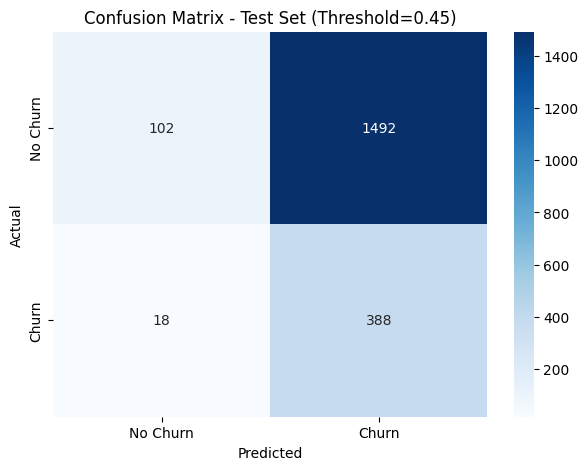

In [35]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Test Set (Threshold=0.45)')
plt.show()

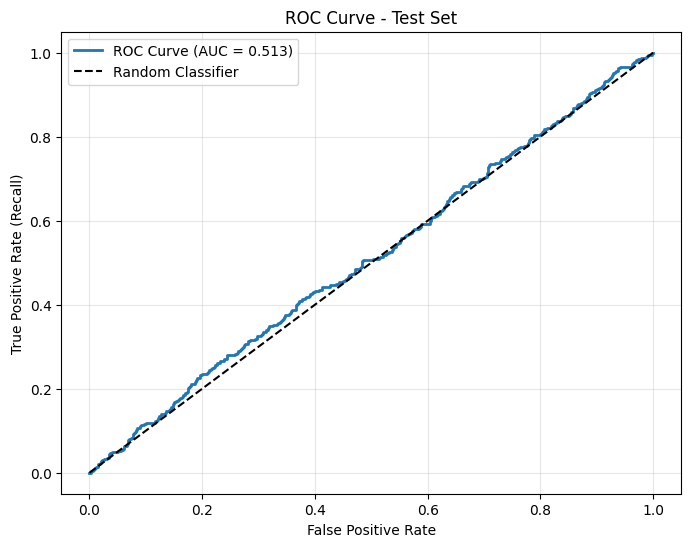

In [36]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# Get feature importance from Logistic Regression
feature_names = X_train_df.columns
coefficients = model.named_steps['model'].coef_[0]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Most Important Features (Logistic Regression)')
plt.tight_layout()
plt.show()

print(importance_df.head(15))

ValueError: All arrays must be of the same length

In [ ]:
# Analyze False Negatives (missed churners)
false_negatives_idx = np.where((y_test == 1) & (y_test_pred == 0))[0]
false_negatives_data = X_test_df.iloc[false_negatives_idx]

print("=== FALSE NEGATIVES (Missed Churners) ===")
print(f"Total: {len(false_negatives_idx)}")
print("\nCharacteristics:")
print(false_negatives_data.describe())

# Analyze False Positives (false alarms)
false_positives_idx = np.where((y_test == 0) & (y_test_pred == 1))[0]
false_positives_data = X_test_df.iloc[false_positives_idx]

print("\n=== FALSE POSITIVES (False Alarms) ===")
print(f"Total: {len(false_positives_idx)}")
print("\nCharacteristics:")
false_positives_data.describe()

=== FALSE NEGATIVES (Missed Churners) ===
Total: 18

Characteristics:
       Gender_Male  Gender_Other  Marital Status_Married  \
count    18.000000     18.000000               18.000000   
mean      0.388889      0.333333                0.666667   
std       0.501631      0.485071                0.485071   
min       0.000000      0.000000                0.000000   
25%       0.000000      0.000000                0.000000   
50%       0.000000      0.000000                1.000000   
75%       1.000000      1.000000                1.000000   
max       1.000000      1.000000                1.000000   

       Marital Status_Single  Job Role_Developer  Job Role_Manager  \
count              18.000000           18.000000         18.000000   
mean                0.333333            0.277778          0.166667   
std                 0.485071            0.460889          0.383482   
min                 0.000000            0.000000          0.000000   
25%                 0.000000           

,Gender_Male,Gender_Other,Marital Status_Married,Marital Status_Single,Job Role_Developer,Job Role_Manager,Job Role_Sales,Department_IT,Department_Marketing,Department_Sales,...,Absenteeism,Distance from Home,Manager Feedback Score,Work_Stress,Dissatisfaction,Stagnation_Flag,Projects_Per_Year,Salary_Performance_Ratio,Commute_Burden,Overwork_Flag
count,1492.000000,1492.0,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,...,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000
mean,0.508713,0.0,0.487936,0.412869,0.401475,0.223190,0.081099,0.383378,0.093834,0.313003,...,9.354558,25.292895,5.474397,0.329771,0.951562,0.545576,5.412269,3.974784,23.728753,0.131367
std,0.500092,0.0,0.500022,0.492515,0.490361,0.416525,0.273079,0.486372,0.291695,0.463871,...,5.781016,14.773020,2.602470,0.229724,0.383991,0.498085,7.329351,3.059029,22.150215,0.337915
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.611220,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,12.000000,3.200000,0.146341,0.680000,0.000000,1.571429,1.907090,5.400000,0.000000
50%,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,25.000000,5.500000,0.297234,0.960000,1.000000,3.087121,2.969330,16.900000,0.000000
75%,1.000000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,14.000000,39.000000,7.700000,0.479676,1.220000,1.000000,5.714286,4.923600,36.150000,0.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,49.000000,10.000000,1.160494,1.880000,1.000000,49.000000,14.949300,93.100000,1.000000


In [38]:
# Save the pipeline
joblib.dump(model, 'employee_churn_model.pkl')

# Save the threshold
import json
config = {
    'threshold': 0.45,
    'expected_recall': 0.956,
    'expected_precision': 0.206,
    'training_date': '2025-10-31',
    'features': list(X_train_df.columns)
}

with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("Model saved successfully!")

Model saved successfully!


In [39]:
# Load model
loaded_model = joblib.load('employee_churn_model.pkl')

# Load config
with open('model_config.json', 'r') as f:
    config = json.load(f)

# Make predictions on new data
new_proba = loaded_model.predict_proba(new_data_df)[:, 1]
new_pred = (new_proba >= config['threshold']).astype(int)

NameError: name 'new_data_df' is not defined